<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Define-blending-model" data-toc-modified-id="Define-blending-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define blending model</a></span></li><li><span><a href="#Calling-blending-doesn't-work-for-John" data-toc-modified-id="Calling-blending-doesn't-work-for-John-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calling blending doesn't work for John</a></span></li><li><span><a href="#Outside-of-a-function-seems-to-be-fine" data-toc-modified-id="Outside-of-a-function-seems-to-be-fine-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Outside of a function seems to be fine</a></span></li><li><span><a href="#Iterating-outside-function" data-toc-modified-id="Iterating-outside-function-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Iterating outside function</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Checking-math-/-demonstration" data-toc-modified-id="Checking-math-/-demonstration-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Checking math / demonstration</a></span></li></ul></div>

# Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
idx = pd.IndexSlice

from gurobipy import *

from random import seed, random

from datetime import datetime
from dateutil.relativedelta import relativedelta
idx = pd.IndexSlice
from cn_mine_simulation_tools import *
from cn_refinery import *
from cn_scrap_supply_tools import *
from cn_demand_tools import *
from cn_price_formation import * 
from cn_blending import *

import warnings
warnings.filterwarnings("ignore") # need to replace datetime, pandas no longer supports

def to_alloy_update(sectorial, s2s, prod_spec):
    # Convert to shapes (only for alloyed scrap):
    unalloyed_quant = 0
    if 'Unalloyed' in sectorial.index:
        unalloyed_quant = sectorial.copy().loc['Unalloyed']
        sectorial.drop('Unalloyed',inplace = True)
    copper_brass = 0
    if 'Copper brass' in sectorial.index:
        copper_brass = sectorial.copy().loc['Copper brass']
        sectorial.drop('Copper brass', inplace = True)
    
    shapes = pd.Series(0,index = s2s.index)
    shapes = sectorial.dot(s2s.div(s2s.sum(axis=0)).fillna(0).transpose())
    if 'Unalloyed' in sectorial.index or 'Unalloyed' in prod_spec.index:
        prod_spec.drop('Unalloyed',inplace=True)
    # Go from shape quantity to scrap & alloy quantity:
    prod_spec.loc[:,'Quantity'] = 0
    for i in shapes.index:
        prod_spec.loc[prod_spec.loc[:,'Category']==i,'Quantity'] = prod_spec.loc[prod_spec.loc[:,'Category']==i,\
                                            'Fraction']*shapes.loc[i]
    if unalloyed_quant != 0:
        prod_spec.loc['Unalloyed','High_Cu':'Low_Fe'] = pd.Series([100, 99.5, 0.01, 0, 0.01, 0, 0.1, 0, 0.1, 0, 0, 0, 0.1, 0, 0.1, 0], index = prod_spec.loc[:,'High_Cu':'Low_Fe'].columns)
        prod_spec.loc['Unalloyed','UNS'] = 'Unalloyed'
        prod_spec.loc['Unalloyed','Alloy Type':'Category'] = prod_spec.iloc[0,:].loc['Alloy Type':'Category']
        prod_spec.loc['Unalloyed','Quantity'] = unalloyed_quant
        
    if copper_brass != 0:
        prod_spec.loc['Copper brass','High_Cu':'Low_Fe'] = pd.Series([100, 98, 0.01, 0, 0.01, 0, 0.1, 0, 0.1, 0, 0, 0, 0.1, 0, 0.1, 0], index = prod_spec.loc[:,'High_Cu':'Low_Fe'].columns)
        prod_spec.loc['Copper brass','UNS'] = 'Copper brass'
        prod_spec.loc['Copper brass','Alloy Type':'Category'] = prod_spec.iloc[0,:].loc['Alloy Type':'Category']
        prod_spec.loc['Copper brass','Quantity'] = copper_brass

    prod_spec.set_index('UNS',inplace=True)
    return prod_spec # for individual alloys

In [7]:
## High level parameters
historical_prod=pd.read_excel('Data/Production data compile.xlsx', sheet_name='Selected', index_col=0).loc[:2018]
historical_prod_cn=pd.read_excel('Data/Production data compile.xlsx', sheet_name='China', index_col=0, usecols='A:O,W:X,AE').loc[:2018]
historical_prod_rw = historical_prod.loc[1950:] - historical_prod_cn.loc[1950:]
historical_price=pd.read_excel('Data/Price data compile.xlsx', sheet_name='Price', index_col=0) # All prices 2017 constant
historical_price.drop(['Grape','Low_brass','Pb_Red_Brass'], axis = 1, inplace = True)
ref_prices_future = pd.read_csv('Data/Future metal prices.csv',index_col=0).loc[:,'Ref_Zn':]
ref_prices_historical = historical_price.loc[:,'Ref_Zn':'Ref_Fe']
ref_prices_historical.drop(2018)
ref_prices_future.index = list(range(2018,2048))
ref_prices = pd.concat([ref_prices_historical,ref_prices_future])

historical_lme_price=historical_price.loc[:, 'LME']
ref_price=pd.concat([historical_price.loc[:,'Ref_Zn':'Ref_Fe'],ref_prices_future])
historical_tcrc=historical_price.loc[:, 'Annual TCRC']
historical_no2=historical_price.loc[:, 'No.2 ref']
historical_sp2=historical_lme_price-historical_no2
historical_no1 = historical_price.loc[:,'Barley brass']
historical_sp1 = historical_lme_price-historical_no1
historical_alloyed = historical_price.loc[:,'Yellow_Brass':'Cartridge']
historical_alloyed = historical_alloyed[sorted(list(historical_alloyed.columns))]
scraps = list(historical_alloyed.columns)
historical_spa = historical_alloyed.apply(lambda x: -x + historical_lme_price)
raw_price = pd.concat([historical_price.loc[:,'Ref_Cu':'Cartridge'],ref_prices_future.loc[2019:,:]],sort=False)
raw_price.loc[:,'No.1'] = historical_no1
raw_price.loc[:,'No.2'] = historical_no2
raw_price.loc[2019:,:] = 0
ref_metals = list(ref_price.columns)
for i in ['Cartridge','Pb_Yellow_Brass']:
    raw_price.loc[1999:2018,i] = raw_price.loc[1999:2018,'Yellow_Brass'] * raw_price.loc[2018,i] / raw_price.loc[2018,'Yellow_Brass']
for i in ['Al_Bronze','Sn_Bronze','Pb_Sn_Bronze']:
    raw_price.loc[1999:2018,i] = raw_price.loc[1999:2018,'Red_Brass'] * raw_price.loc[2018,i] / raw_price.loc[2018,'Red_Brass']
for i in ['Mn_Bronze','Ni_Ag']:
    raw_price.loc[1999:2018,i] = raw_price.loc[1999:2018,'Ocean'] * raw_price.loc[2018,i] / raw_price.loc[2018,'Ocean']
    # used their compositions to decide which of our real-data prices to follow - subjective


## Semis demand parameters
fruity_alloys = pd.read_excel('Data/semis demand/Fruity alloys.xlsx', sheet_name='Sheet1', index_col=0)
og_fruity_alloys = fruity_alloys.copy()
fruity_alloyed = fruity_alloys.copy().loc[fruity_alloys.loc[:,'Alloy Type'] != 'No.1']
fruity_alloyed.loc['Fruity No.1',:] = fruity_alloys.loc['Mainboard',:].copy()
fruity_alloyed.loc['Fruity No.1','Quantity'] = fruity_alloys.loc[fruity_alloys.loc[:,'Alloy Type']=='No.1','Quantity'].sum()
og_fruity_alloyed = fruity_alloyed.copy()



ut_db = pd.Series(1,index=np.arange(1960,2041))
# Set rollover to 1 for previous year's scrap becoming the new year's scrap
rollover = 1
# Set scrappy to 1 for scrap balance being determined by scrap consumption from blending rather than semis demand, set it to 2 to only use the subset of scraps described by scrap_subset variable
scrappy = 2
# scrap_subset = ['No.1', 'No.2', 'Cartridge', 'Ocean', 'Red_Brass', 'Yellow_Brass',    'Pb_Yellow_Brass']
scrap_subset = list(['Yellow_Brass','Cartridge', 'No.1', 'No.2', 'Pb_Yellow_Brass', 'Ocean', 
                     'Red_Brass', 'Al_Bronze', 'Ni_Ag'])
# scrap_subset = ['No.1']
# scrap_subset = ['No.1', 'No.2', 'Al_Bronze', 'Cartridge', 'Ni_Ag', 'Ocean',
#        'Pb_Sn_Bronze', 'Pb_Yellow_Brass', 'Red_Brass', 'Yellow_Brass'] # leaving out tin bronze since it has the lowest use fraction
# Set include_unalloyed to 1 to expand semis to include unalloyed production, rather than only alloyed, set to 2 to permit fraction of unalloyed degree of freedom in blending, also requires fraction_unalloyed_brass=0.135
include_unalloyed = 2
# Set inventory to 1 to use scrap entering inventory minus scrap leaving inventory as the scrap supply-demand balance rather than all scrap available minus scrap demand
inventory = 1
# Set use_Ref_Cu to 1 to use the refined copper demand coming from blending as our copper demand
use_Ref_Cu = 1
# Set slow_change != 0 to keep blending from changing so quickly year-over-year, value is percent change permitted per year
slow_change = 0
# fraction_yellows is fraction of Yellow_Brass, Pb_Yellow_Brass, and Cartridge allowed in secondary refineries , while unalloyed tune changes the availability of No.1 and No.2 scraps in the blending module. Default 1 means they both have availability equal to total unalloyed quantity
fraction_yellows = 0.05 # set to zero to avoid this method, which includes secondary refineries in blending
unalloyed_tune = 1
use_new_recovery = 0 # set to 1 to use fraction_no1_old and new to determine No.1/No.2 ratio of unalloyed scrap, 0 uses No.2 quantity = secondary refinery demand 
refined_import_rate = 1 # refined imports, 1 is default
CU_ref_bal_elas = 0 # random estimate for how much refinery supply-demand ratio impacts CU, should be negative, 0 for default
fruity_alloys = og_fruity_alloys.copy()
fruity_alloyed = fruity_alloys.copy().loc[fruity_alloys.loc[:,'Alloy Type'] != 'No.1']
# fruity_alloyed.loc['Fruity No.1',:] = fruity_alloys.loc['Mainboard',:].copy()
# fruity_alloyed.loc['Fruity No.1','Quantity'] = fruity_alloys.loc[fruity_alloys.loc[:,'Alloy Type']=='No.1','Quantity'].sum()
# fruity_alloys.loc[:'Mesa','Quantity'] *= 10
fruity_multiplier = 1 # 0.1*30997.694215369822/og_fruity_alloys.loc[:,'Quantity'].sum() # 1 is default, 30997 is 2018 direct_melt_sectorial_demand value, the leading value (eg 0.01) would be the fraction of market occupied by these alloys
pir_pcr = 1
pir_fraction = -1
# fruity_rr = [0.01,0.01,0.01,0.01]
# scrap_bal_correction = 0.945 # 0.928
# other_pir_price = 0.9
fruity_rr = [0.01,0.01,0.01,0.01,0,0,0,0]
scrap_bal_correction = 0.945
other_pir_price = 0.65
pir_price= 0.65
scrap_bal_loss = 1
fraction_unalloyed_brass = 0.135


# raw_price.loc[1960:1998, 'Ref_Cu'] = cathode_price_series.loc[pd.datetime(1960, 1, 1):pd.datetime(1998, 1, 1)].values
# raw_price.loc[1960,'Ref_Zn':'Cartridge'] = raw_price.loc[1999,'Ref_Zn':'Cartridge'] / raw_price.loc[1999,'Ref_Cu'] \
#     * raw_price.loc[1960,'Ref_Cu']
# raw_price.loc[1960,'No.1':'No.2'] = raw_price.loc[1993,'No.1':'No.2'] / raw_price.loc[1993,'Ref_Cu'] \
#     * raw_price.loc[1960,'Ref_Cu']
# raw_price.loc[1961:1998,'Ref_Zn':'Cartridge'] = raw_price.loc[1961:1998,'Ref_Cu'].apply(
#     lambda x: x * raw_price.loc[1999,'Ref_Zn':'Cartridge'] / raw_price.loc[1999,'Ref_Cu'])
# raw_price.loc[1961:1992,'No.1':'No.2'] = raw_price.loc[1961:1992,'Ref_Cu'].apply(
#     lambda x: x * raw_price.loc[1999,'No.1':'No.2'] / raw_price.loc[1999,'Ref_Cu'])
# raw_price_cn = raw_price.copy()
# raw_price_rw = raw_price.copy() # assuming that china's scrap prices may differ from those of the row due to the ban

# Initialize simulation time
history_start_time='19600101'
simulation_start_time='20180101'
simulation_end_time='20400101'
simulation_time=pd.date_range(simulation_start_time, simulation_end_time, freq='AS')
history_time=pd.date_range(history_start_time, simulation_start_time, freq='AS')

# Cathode price
cathode_price_series=pd.Series(0, index=history_time)
cathode_price_series.loc[:'20180101']=historical_lme_price.values
cathode_bal_l1 = pd.Series(0, index = np.arange(2018,2041))

# TCRC
tcrc_series=pd.Series(0, index=history_time)
tcrc_series.loc[:'20180101']=historical_tcrc.values

# Scrap spreads (No.2, No.1, alloyed)
sp2_series=pd.Series(0, index=history_time)
sp2_series.loc[:'20180101']=historical_sp2.values
sp2_series_cn=pd.Series(0, index=history_time)
sp2_series_cn.loc[:'20180101']=historical_sp2.values
sp2_series_rw=pd.Series(0, index=history_time)
sp2_series_rw.loc[:'20180101']=historical_sp2.values
sp1_series = pd.Series(0, index=history_time)
sp1_series.loc[:'20180101'] = historical_sp1.values
sp1_series_cn = pd.Series(0, index=history_time)
sp1_series_cn.loc[:'20180101'] = historical_sp1.values
sp1_series_rw = pd.Series(0, index=history_time)
sp1_series_rw.loc[:'20180101'] = historical_sp1.values
spa_series = pd.DataFrame(0, index=history_time, columns=scraps)
spa_series.loc[:'20180101']= historical_spa.values
spa_series_cn = pd.DataFrame(0, index=history_time, columns=scraps)
spa_series_cn.loc[:'20180101']= historical_spa.values
spa_series_rw = pd.DataFrame(0, index=history_time, columns=scraps)
spa_series_rw.loc[:'20180101']= historical_spa.values

## Semis demand parameters
gdp_growth_prediction_base=pd.read_excel('Data/semis demand/Demand prediction data.xlsx', sheet_name='GDP growth', index_col=0, usecols=np.arange(6))
volume_prediction_base=pd.read_excel('Data/semis demand/Demand prediction data.xlsx', sheet_name='All sectors', index_col=0, header=[0,1])
intensity_prediction=pd.read_excel('Data/semis demand/Intensity initial.xls', sheet_name='Sheet1', index_col=0, header=[0,1])
elas_sec_reg=pd.read_excel('Data/semis demand/Elasticity estimates.xlsx', sheet_name='S+R S intercept only', index_col=0)
sector_shape_matrix=pd.read_excel('Data/semis demand/Sector to shape matrix updated.xlsx', sheet_name='Sheet1', index_col=0)
calibration_1718=pd.read_excel('Data/semis demand/2017 and 2018 calibration.xlsx', sheet_name='Sheet1', index_col=0)

# Adjust demand in 2018 to scale it back to ICSG
intensity_prediction.loc[2017, :] = intensity_prediction.loc[2017, :]\
.mul(calibration_1718.loc[2017, 'ICSG refined usage']).div(calibration_1718.loc[2017, 'simulated refined usage'])
intensity_prediction.loc[2018, :] = intensity_prediction.loc[2018, :]\
.mul(calibration_1718.loc[2018, 'ICSG refined usage']).div(calibration_1718.loc[2018, 'simulated refined usage'])
demand_prediction=volume_prediction_base.loc[2015:, :].mul(intensity_prediction.fillna(0))

## Scrap supply parameters
use_sector_combined=pd.read_excel('Data/scrap supply/End use combined data.xlsx', sheet_name='Combined', index_col=0)
sector_to_product=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='sector to product', index_col=0)
product_to_waste=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='product to waste', index_col=0)
product_life_and_eff=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='product lifetime and efficiency', index_col=0)
product_to_cathode_alloy=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='product to copper or alloy', index_col=0)
product_to_copper_alloy=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='prod to Cu, Cu brass, alloy', index_col=0)
recycle_efficiency=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='recycling efficiency', index_col=0)

# Home scrap ratio
home_scrap_ratio_file=pd.read_excel('Data/scrap supply/Home scrap ratio.xls', sheet_name='Sheet1', index_col=0)
home_scrap_ratio_series=home_scrap_ratio_file.loc[:, 'Calibrated ratio']
exchange_scrap_ratio_series=0.9-home_scrap_ratio_series

# Sector end use to product matrix 
use_product_history = use_sector_combined.apply(lambda x: (x*sector_to_product).sum(axis=1),axis=1)
# use_product_history=pd.DataFrame(np.matmul(use_sector_combined, sector_to_product.transpose()), 
#                                  index=use_sector_combined.index, columns=sector_to_product.index)
demand_fractions = pd.read_excel('Data/semis demand/demand_analysis_copper_lto_q2_2016.xls', sheet_name='Analysis', index_col = 0)
cn_demand_fraction = demand_fractions.loc[:,'China Fraction']
rw_demand_fraction = 1 - cn_demand_fraction
use_product_history_cn = use_product_history.apply(lambda x: x*cn_demand_fraction.loc[:2018])
use_product_history_rw = use_product_history.apply(lambda x: x*rw_demand_fraction.loc[:2018])

# Product to waste matrices
product_to_waste_collectable=product_to_waste.iloc[:, :-2]
product_to_waste_no_loss=product_to_waste_collectable.mul(1/product_to_waste_collectable.sum(axis=1), axis=0)

# Availability-specific parameters
s2s = pd.read_excel('Data/Shape-Sector Distributions.xlsx', index_col=0)
prod_spec = pd.read_excel('Data/Prod_spec_20200311_no_low.xlsx')
raw_spec = pd.read_excel('Data/Raw_spec_201901.xlsx',index_col=0)
raw_spec.drop(['Grape','Low_brass','Pb_Red_Brass'],inplace=True)
for i in prod_spec.index:
    prod_spec.loc[i,'UNS'] = prod_spec.loc[i,'UNS']+' '+prod_spec.loc[i,'Category']
    
# Product lifetime parameters and frequencies
product_lifetime=product_life_and_eff.loc[:, 'Lifetime']
product_lifetime_cn = product_life_and_eff.loc[:, 'CN Lifetime']
product_lifetime_df=lifetime_df(product_lifetime)
product_lifetime_df_cn = lifetime_df(product_lifetime_cn)
product_lifetime_freq_df=lifetime_freq_df(product_lifetime_df)
product_lifetime_freq_df_cn = lifetime_freq_df(product_lifetime_df_cn)

# Recycling and fabrication efficiencies
sort_eff=recycle_efficiency.iloc[:, 0]
sort_eff_cn = recycle_efficiency.iloc[:, 2]
collect_rate=recycle_efficiency.iloc[:, 1]
collect_rate_cn = recycle_efficiency.iloc[:, 3]
fab_eff=product_life_and_eff.loc[:, 'Fabrication efficiency']
fab_eff_cn = product_life_and_eff.loc[:, 'CN Fabrication efficiency']
new_scrap_gen=1/fab_eff-1
new_scrap_gen_cn = 1/fab_eff_cn-1
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sort_eff_series_cn = pd.DataFrame(np.array((list(sort_eff_cn)*23)).reshape(23, 6), index = np.arange(2018,2041), columns = sort_eff_cn.index)
collect_rate_series=pd.DataFrame(np.array((list(collect_rate)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=collect_rate.index)
collect_rate_series_cn=pd.DataFrame(np.array((list(collect_rate_cn)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=collect_rate_cn.index)

fraction_no1_old = pd.Series({'Plumbing': 0.7,'Building Plant': 0.7,'Architecture': 0.7, 'Communications': 0.5, 
                           'Electrical Power': 0.7,'Telecommunications': 0.7,'Power Utility': 0.7,
                           'Electrical Industrial': 0.2, 'Non Elec. Industrial':0.1, 'Electrical Automotive': 0.1,
                           'Non Elec. Automotive': 0.1, 'Other Transport': 0.1, 'Consumer': 0.1, 'Cooling': 0.1, 
                           'Electronic': 0.1, 'Diverse': 0.1})
fraction_no1_new = pd.Series({'Plumbing': 0.9,'Building Plant': 0.9,'Architecture': 0.9, 'Communications': 0.9, 
                           'Electrical Power': 0.9,'Telecommunications': 0.9,'Power Utility': 0.9,
                           'Electrical Industrial': 0.7, 'Non Elec. Industrial':0.7, 'Electrical Automotive': 0.5,
                           'Non Elec. Automotive': 0.7, 'Other Transport': 0.7, 'Consumer': 0.7, 'Cooling': 0.8, 
                           'Electronic': 0.3, 'Diverse': 0.7})

## Price formation parameters
price_formation_param=pd.read_excel('Data/price formation/Price formation.xlsx', sheet_name='Sheet1', index_col=0)
cathode_sd_elas=price_formation_param.loc['Cathode SD elasticity', 'Value']
conc_sd_elas=price_formation_param.loc['Concentrate SD elasticity', 'Value']
cathode_sp2_elas=price_formation_param.loc['SP2 cathode elasticity', 'Value']
sp2_sd_elas=price_formation_param.loc['SP2 SD elasticity', 'Value']
cathode_sp1_elas=price_formation_param.loc['SP1 cathode elasticity', 'Value']
sp1_sd_elas=price_formation_param.loc['SP1 SD elasticity', 'Value']
cathode_alloyed_elas=price_formation_param.loc['SP2 SD elasticity', 'Value']
alloyed_sd_elas=price_formation_param.loc['SP Alloy SD elasticity', 'Value']

# Initialize end use by product stats
use_product_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=use_product_history.columns)
use_product_all_life=pd.concat([use_product_history, use_product_future])
use_product_future_cn=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=use_product_history_cn.columns)
use_product_all_life_cn=pd.concat([use_product_history_cn, use_product_future_cn])
use_product_future_rw=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=use_product_history_rw.columns)
use_product_all_life_rw=pd.concat([use_product_history_rw, use_product_future_rw])

# Initialize old scrap history
product_eol_history_cn=product_reach_eol(use_product_history_cn, product_lifetime_freq_df_cn)
product_eol_history_rw=product_reach_eol(use_product_history_rw, product_lifetime_freq_df)
product_eol_history=product_eol_history_cn + product_eol_history_rw
# product_eol_history = product_reach_eol(use_product_history, product_lifetime_freq_df)
# waste_from_old_history_cn=pd.DataFrame(np.matmul(product_eol_history_cn, product_to_waste_collectable), 
#                                      index=product_eol_history_cn.index, 
#                                      columns=product_to_waste_collectable.columns).mul(sort_eff_cn).mul(collect_rate_cn)
waste_from_old_history_cn = product_eol_history_cn.apply(lambda x: (x*product_to_waste_collectable.T).sum(axis=1)
                                                      ,axis=1).mul(sort_eff_cn).mul(collect_rate_cn)
# waste_from_old_history_rw=pd.DataFrame(np.matmul(product_eol_history_rw, product_to_waste_collectable), 
#                                      index=product_eol_history_rw.index, 
#                                      columns=product_to_waste_collectable.columns).mul(sort_eff).mul(collect_rate)
waste_from_old_history_rw = product_eol_history_rw.apply(lambda x: (x*product_to_waste_collectable.T).sum(axis=1)
                                                      ,axis=1).mul(sort_eff).mul(collect_rate)
# waste_from_old_history=pd.DataFrame(np.matmul(product_eol_history, product_to_waste_collectable), 
#                                      index=product_eol_history.index, 
#                                      columns=product_to_waste_collectable.columns).mul(sort_eff).mul(collect_rate)
waste_from_old_history = waste_from_old_history_cn + waste_from_old_history_rw
waste_from_old_future_cn=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_old_future_rw=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_old_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_old_all_life_cn=pd.concat([waste_from_old_history_cn, waste_from_old_future_cn])
waste_from_old_all_life_rw=pd.concat([waste_from_old_history_rw, waste_from_old_future_rw])
waste_from_old_all_life=pd.concat([waste_from_old_history, waste_from_old_future])

ref_hyper_param=pd.read_excel('Data/refined supply/Refinery hyperparameter.xlsx', sheet_name='Parameters', index_col=0)
ref_hyper_param_cn = pd.read_excel('Data/refined supply/Refinery hyperparameter.xlsx', sheet_name='CN Parameters', index_col=0)
ref_hyper_param_rw = pd.read_excel('Data/refined supply/Refinery hyperparameter.xlsx', sheet_name='RW Parameters', index_col=0)
scrap_to_cathode_eff=ref_hyper_param.loc['scrap to cathode eff', 'Value']

# Old scrap available 
old_scrap_available_history_cn = old_scrap_gen_init(product_eol_history_cn, product_to_waste_collectable, product_to_cathode_alloy,
                                     collect_rate_cn, sort_eff_cn, prod_spec.copy(), s2s, fraction_no1_old)
old_scrap_available_history_rw = old_scrap_gen_init(product_eol_history_rw, product_to_waste_collectable, product_to_cathode_alloy,
                                     collect_rate, sort_eff, prod_spec.copy(), s2s, fraction_no1_old)
# old_scrap_available_history = old_scrap_gen_init(product_eol_history, product_to_waste_collectable, product_to_cathode_alloy,
#                                      collect_rate, sort_eff, prod_spec.copy(), s2s, fraction_no1 = 0.1)
old_scrap_available_history = old_scrap_available_history_cn + old_scrap_available_history_rw

old_scrap_available_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=old_scrap_available_history.columns)
old_scrap_available_future_cn=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=old_scrap_available_history_cn.columns)
old_scrap_available_future_rw=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=old_scrap_available_history_rw.columns)
old_scrap_available_cn = pd.concat([old_scrap_available_history_cn, old_scrap_available_future_cn])
old_scrap_available_rw = pd.concat([old_scrap_available_history_rw, old_scrap_available_future_rw])
old_scrap_available = pd.concat([old_scrap_available_history, old_scrap_available_future])

# Initialize direct melt demand, needed up here for scaling fruity alloyed
direct_melt_sectorial_demand_cn=(use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Alloyed'])
direct_melt_sectorial_demand_rw=(use_product_all_life_rw*product_to_cathode_alloy.loc[:, 'Alloyed'])
direct_melt_sectorial_demand = direct_melt_sectorial_demand_cn + direct_melt_sectorial_demand_rw

historical_ref_imports_cn = pd.Series(0,index=np.arange(1960,2041))
historical_ref_imports_cn.loc[:2018] = historical_prod_cn.loc[:, 'Net Refined Imports'].copy()
historical_ref_imports_cn.loc[2019:] = historical_ref_imports_cn.loc[2018]
historical_ref_imports_cn.loc[:1974] += historical_prod_cn.loc[:1974,'Semis Imports (COMTRADE, kt)']
og_historical_ref_imports_cn = historical_ref_imports_cn.copy()

if include_unalloyed == 1:
#     direct_melt_sectorial_demand.loc[:,'Unalloyed'] = (use_product_all_life*product_to_cathode_alloy.loc[:, 'Copper']).sum(axis = 1)
    direct_melt_sectorial_demand_cn.loc[:,'Unalloyed'] = (use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Copper']).sum(axis = 1)
    direct_melt_sectorial_demand_rw.loc[:,'Unalloyed'] = (use_product_all_life_rw*product_to_cathode_alloy.loc[:, 'Copper']).sum(axis = 1)
    direct_melt_sectorial_demand.loc[:, 'Unalloyed'] = direct_melt_sectorial_demand_cn.loc[:, 'Unalloyed'] + direct_melt_sectorial_demand_rw.loc[:, 'Unalloyed']
    # Including imports
    direct_melt_sectorial_demand_cn.loc[1960:2018, 'Unalloyed'] -= historical_ref_imports_cn.loc[1960:2018]
    direct_melt_sectorial_demand_rw.loc[1960:2018, 'Unalloyed'] += historical_ref_imports_cn.loc[1960:2018]
#     direct_melt_sectorial_demand_cn.loc[:, 'Unalloyed'] = use_product_all_life_cn.sum(axis=1) - direct_melt_sectorial_demand_cn.sum(axis = 1)
#     direct_melt_sectorial_demand_rw.loc[:, 'Unalloyed'] = direct_melt_sectorial_demand.loc[:,'Unalloyed'] - direct_melt_sectorial_demand_cn.loc[:,'Unalloyed']
elif include_unalloyed == 2:
    direct_melt_sectorial_demand_cn.loc[:,'Unalloyed'] = (use_product_all_life_cn*product_to_copper_alloy.loc[:, 'Copper']).sum(axis = 1)
    direct_melt_sectorial_demand_rw.loc[:,'Unalloyed'] = (use_product_all_life_rw*product_to_copper_alloy.loc[:, 'Copper']).sum(axis = 1)
    direct_melt_sectorial_demand.loc[:, 'Unalloyed'] = direct_melt_sectorial_demand_cn.loc[:, 'Unalloyed'] + direct_melt_sectorial_demand_rw.loc[:, 'Unalloyed']
    direct_melt_sectorial_demand_cn.loc[:,'Copper brass'] = (use_product_all_life_cn*product_to_copper_alloy.loc[:, 'Copper brass']).sum(axis = 1)
    direct_melt_sectorial_demand_rw.loc[:,'Copper brass'] = (use_product_all_life_rw*product_to_copper_alloy.loc[:, 'Copper brass']).sum(axis = 1)
    direct_melt_sectorial_demand.loc[:, 'Copper brass'] = direct_melt_sectorial_demand_cn.loc[:, 'Copper brass'] + direct_melt_sectorial_demand_rw.loc[:, 'Copper brass']
    # Including imports
    direct_melt_sectorial_demand_cn.loc[1960:2018, 'Unalloyed'] -= historical_ref_imports_cn.loc[1960:2018]*(1-fraction_unalloyed_brass)
    direct_melt_sectorial_demand_rw.loc[1960:2018, 'Unalloyed'] += historical_ref_imports_cn.loc[1960:2018]*(1-fraction_unalloyed_brass)
    direct_melt_sectorial_demand_cn.loc[1960:2018, 'Copper brass'] -= historical_ref_imports_cn.loc[1960:2018]*fraction_unalloyed_brass
    direct_melt_sectorial_demand_rw.loc[1960:2018, 'Copper brass'] += historical_ref_imports_cn.loc[1960:2018]*fraction_unalloyed_brass
    direct_melt_sectorial_demand.loc[1960:2018, 'Unalloyed'] = direct_melt_sectorial_demand_cn.loc[1960:2018,'Unalloyed'] + direct_melt_sectorial_demand_rw.loc[1960:2018,'Unalloyed']
    direct_melt_sectorial_demand.loc[1960:2018, 'Copper brass'] = direct_melt_sectorial_demand_cn.loc[1960:2018,'Copper brass'] + direct_melt_sectorial_demand_rw.loc[1960:2018,'Copper brass']


# Initialize new scrap history
waste_from_new_history_cn=pd.DataFrame(0, index=waste_from_old_history_cn.index, columns=product_to_waste_collectable.columns)
waste_from_new_history_rw=pd.DataFrame(0, index=waste_from_old_history_rw.index, columns=product_to_waste_collectable.columns)
waste_from_new_history=pd.DataFrame(0, index=waste_from_old_history.index, columns=product_to_waste_collectable.columns)
new_scrap_available_history_cn = pd.DataFrame(0, index = product_eol_history_cn.index, columns = old_scrap_available_history_cn.columns)
new_scrap_available_history_rw = pd.DataFrame(0, index = product_eol_history_rw.index, columns = old_scrap_available_history_rw.columns)
new_scrap_available_history = pd.DataFrame(0, index = product_eol_history.index, columns = old_scrap_available_history.columns)
new_scrap_alloys_cn = pd.DataFrame(0, index = product_eol_history_cn.index, columns = list(prod_spec.loc[:,'Primary code'].unique())+list(['New No.1'])+list(fruity_alloyed.index))
new_scrap_alloys_rw = pd.DataFrame(0, index = product_eol_history_rw.index, columns = list(prod_spec.loc[:,'Primary code'].unique())+list(['New No.1'])+list(fruity_alloyed.index))
prod_spec_cop = prod_spec.copy()
for i in prod_spec_cop.index:
    prod_spec_cop.loc[i+prod_spec.shape[0],:] = prod_spec_cop.loc[i,:]
    prod_spec_cop.loc[i+prod_spec.shape[0],'UNS'] = prod_spec_cop.loc[i,'UNS'] + '_rw'
annual_recycled_content = pd.DataFrame(0, index = np.arange(1960,2041), columns = list(prod_spec_cop.loc[:,'UNS'])+list(fruity_alloys.index)+list(['Unalloyed CN', 'Unalloyed RoW', 'Secondary refined CN', 'Secondary refined RoW']))
annual_recycled_volume = pd.DataFrame(0, index = np.arange(1960,2041), columns = list(prod_spec_cop.loc[:,'UNS'])+list(fruity_alloys.index)+list(['Unalloyed CN', 'Unalloyed RoW', 'Secondary refined CN', 'Secondary refined RoW']))

for year_i in new_scrap_available_history.index:
    home_scrap_ratio=home_scrap_ratio_series.loc[year_i]
    exchange_scrap_ratio=exchange_scrap_ratio_series.loc[year_i]
    ######################################### unsure about this new_scrap_gen_cn and the fabrication efficiencies associated with it
    waste_from_new_year_i_cn=\
    simulate_new_scrap_one_year(year_i, use_product_history_cn, new_scrap_gen_cn, product_to_waste_no_loss, sort_eff_cn, 
                                home_scrap_ratio, exchange_scrap_ratio)
    waste_from_new_history_cn.loc[year_i]=waste_from_new_year_i_cn.values
    waste_from_new_year_i_rw=\
    simulate_new_scrap_one_year(year_i, use_product_history_rw, new_scrap_gen, product_to_waste_no_loss, sort_eff, 
                                home_scrap_ratio, exchange_scrap_ratio)
    waste_from_new_history_rw.loc[year_i]=waste_from_new_year_i_rw.values
#     waste_from_new_year_i=\
#     simulate_new_scrap_one_year(year_i, use_product_history, new_scrap_gen, product_to_waste_no_loss, sort_eff, 
#                                 home_scrap_ratio, exchange_scrap_ratio)
    waste_from_new_history.loc[year_i]=waste_from_new_year_i_cn.values + waste_from_new_year_i_rw.values
    
    # Initialize new scrap availability history
    if pir_pcr == 0:
        new_scrap_available_year_i_cn = \
        new_scrap_gen_oneyear(use_product_history_cn.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, 
                              collect_rate_cn, sort_eff_cn, prod_spec.copy(), s2s, new_scrap_gen_cn, exchange_scrap_ratio, 
                              home_scrap_ratio, fraction_no1_new)
        new_scrap_available_year_i_rw = \
        new_scrap_gen_oneyear(use_product_history_rw.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, 
                              collect_rate, sort_eff, prod_spec.copy(), s2s, new_scrap_gen, exchange_scrap_ratio, 
                              home_scrap_ratio, fraction_no1_new)
    else:
        if fruity_multiplier != 0:
            fruity_alloyed.loc[:,'Quantity'] = fruity_multiplier*og_fruity_alloyed.loc[:,'Quantity']/direct_melt_sectorial_demand.loc[2018].sum()*direct_melt_sectorial_demand.loc[year_i].sum()
            while 0.3*direct_melt_sectorial_demand.loc[year_i,'Diverse'] < fruity_alloyed.loc[:,'Quantity'].sum():
                fruity_alloyed.loc[:,'Quantity'] *= 0.5
                print('New scrap alloyed reduced')
            
        new_scrap_available_year_i_cn, new_scrap_alloys_cn_year_i = \
        new_scrap_gen_oneyear(use_product_history_cn.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, 
                              collect_rate_cn, sort_eff_cn, prod_spec.copy(), s2s, new_scrap_gen_cn, exchange_scrap_ratio, 
                              home_scrap_ratio, fraction_no1_new, pir_pcr, fruity_alloyed)
        new_scrap_available_year_i_rw, new_scrap_alloys_rw_year_i = \
        new_scrap_gen_oneyear(use_product_history_rw.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, 
                              collect_rate, sort_eff, prod_spec.copy(), s2s, new_scrap_gen, exchange_scrap_ratio, 
                              home_scrap_ratio, fraction_no1_new, 2, fruity_alloyed)
        new_scrap_alloys_cn_year_i.loc[new_scrap_alloys_cn_year_i.loc[:,'Availability'] < 0,'Availability'] = 0
        new_scrap_alloys_cn_year_i.loc[new_scrap_alloys_cn_year_i.loc[:,'Availability'] < 0,'Availability'] = 0
        
    new_scrap_available_history_cn.loc[year_i] = new_scrap_available_year_i_cn
    new_scrap_available_history_rw.loc[year_i] = new_scrap_available_year_i_rw
    new_scrap_available_history.loc[year_i] = new_scrap_available_year_i_cn + new_scrap_available_year_i_rw
    if pir_pcr != 0:
        new_scrap_alloys_cn.loc[year_i] = new_scrap_alloys_cn_year_i.loc[:,'Availability']
        new_scrap_alloys_rw.loc[year_i] = new_scrap_alloys_rw_year_i.loc[:,'Availability']
    else:
        new_scrap_alloys_cn = 0
        new_scrap_alloys_rw = 0
# waste_from_new_history = waste_from_new_history_cn + waste_from_new_history_rw
# new_scrap_available_history = new_scrap_available_history_cn + new_scrap_available_history_rw
if pir_pcr != 0:
    new_scrap_alloys_compositions = new_scrap_alloys_cn_year_i.loc[:,:'Low_Fe']
else:
    new_scrap_alloys_compositions = 0

waste_from_new_future_cn=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_new_future_rw=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_new_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_new_all_life_cn=pd.concat([waste_from_new_history_cn, waste_from_new_future_cn])
waste_from_new_all_life_rw=pd.concat([waste_from_new_history_rw, waste_from_new_future_rw])
waste_from_new_all_life=pd.concat([waste_from_new_history, waste_from_new_future])
new_scrap_available_future_cn = pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns = new_scrap_available_history_cn.columns)
new_scrap_available_future_rw = pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns = new_scrap_available_history_rw.columns)
new_scrap_available_future = pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns = new_scrap_available_history.columns)
new_scrap_available_cn = pd.concat([new_scrap_available_history_cn, new_scrap_available_future_cn])
new_scrap_available_rw = pd.concat([new_scrap_available_history_rw, new_scrap_available_future_rw])
new_scrap_available = pd.concat([new_scrap_available_history, new_scrap_available_future])

# Assumes China scrap distribution is the same as the rest of the world
waste_all_life_cn=waste_from_old_all_life_cn+waste_from_new_all_life_cn
waste_all_life_rw=waste_from_old_all_life_rw+waste_from_new_all_life_rw
waste_imports_cn_all = (waste_all_life_rw.apply(lambda x: x / waste_all_life_rw.sum(axis=1) * \
                          historical_prod_cn.loc[:,'Copper Scrap Imports, COMTRADE (kt)'])).loc[1960:2040]
scrap_imports_cn_all = (old_scrap_available_rw.apply(lambda x: x / old_scrap_available_rw.sum(axis=1) * \
                          historical_prod_cn.loc[:,'Copper Scrap Imports, COMTRADE (kt)'])).loc[1960:2040]

# China's future imports
for i in waste_imports_cn_all.loc[2019:].index:
    waste_imports_cn_all.loc[i,:] = waste_imports_cn_all.loc[2018, :]
for i in scrap_imports_cn_all.loc[2019:].index:
    scrap_imports_cn_all.loc[i, :] = scrap_imports_cn_all.loc[2018, :]
og_scrap_imports_cn_all = scrap_imports_cn_all.copy()
    
# Summing to produce all available scraps
waste_all_life_cn += waste_imports_cn_all
waste_all_life_rw -= waste_imports_cn_all
waste_all_life = waste_all_life_cn + waste_all_life_rw
old_scrap_available_cn = old_scrap_available_cn + scrap_imports_cn_all
old_scrap_available_rw = old_scrap_available_rw - scrap_imports_cn_all
old_scrap_available = old_scrap_available_cn + old_scrap_available_rw
all_scrap_available_cn = old_scrap_available_cn + new_scrap_available_cn
all_scrap_available_rw = old_scrap_available_rw + new_scrap_available_rw
all_scrap_available = all_scrap_available_cn + all_scrap_available_rw
total_unalloyed_cn = old_scrap_available_cn.loc[:,'No.1':'No.2'].sum(axis = 1)
total_unalloyed_rw = old_scrap_available_rw.loc[:,'No.1':'No.2'].sum(axis = 1)
total_unalloyed = old_scrap_available.loc[:,'No.1':'No.2'].sum(axis = 1)


# assuming historical No.1/No.2 ratio is at the 2018 value into the past
if use_new_recovery == 0:
    old_scrap_available_cn.loc[:,'No.1'] = total_unalloyed_cn.loc[:] - historical_prod_cn.loc[:, 'Secondary refining production'] / scrap_to_cathode_eff * 0.85
    old_scrap_available_rw.loc[:,'No.1'] = total_unalloyed_rw.loc[:] - historical_prod_rw.loc[:, 'Secondary refining production'] / scrap_to_cathode_eff * 0.85
    # all_scrap_available.loc[:,'No.1'] = total_unalloyed.loc[:] - historical_prod.loc[:, 'Secondary refining production'] / scrap_to_cathode_eff
    # all_scrap_available.loc[:,'No.2'] = historical_prod.loc[:, 'Secondary refining production'] / scrap_to_cathode_eff
    old_scrap_available_cn.loc[:,'No.2'] = historical_prod_cn.loc[:, 'Secondary refining production'] / scrap_to_cathode_eff * 0.85
    old_scrap_available_rw.loc[:,'No.2'] = historical_prod_rw.loc[:, 'Secondary refining production'] / scrap_to_cathode_eff * 0.85
old_scrap_available.loc[:, 'No.1'] = old_scrap_available_cn.loc[:, 'No.1'] + old_scrap_available_rw.loc[:, 'No.1']
old_scrap_available.loc[:, 'No.2'] = old_scrap_available_cn.loc[:, 'No.2'] + old_scrap_available_rw.loc[:, 'No.2']


all_scrap_available_no_accumulation = all_scrap_available.copy() 
all_scrap_available_no_accumulation_cn = all_scrap_available_cn.copy() 
all_scrap_available_no_accumulation_rw = all_scrap_available_rw.copy() 
old_scrap_available_no_accumulation = old_scrap_available.copy() 
old_scrap_available_no_accumulation_cn = old_scrap_available_cn.copy() 
old_scrap_available_no_accumulation_rw = old_scrap_available_rw.copy() 
# no_accumulation translates to the scrap entering the market that year - the increase in inventory that 
# I'm thinking works as scrap supply for deterimining the supply-demand balance, while total_scrap_demand_all_life 
# with scrappy=1 gives the scrap demand, or the scrap leaving inventory in that year

# Removing new scrap that is now in alloy form
# if pir_pcr != 0:
# #     all_scrap_no_new_cn = all_scrap_available_cn.copy()
# #     all_scrap_no_new_rw = all_scrap_available_rw.copy()
# #     all_scrap_no_new_cn.loc[:,'Al_Bronze':] -= alloy_to_scrap(new_scrap_alloys_cn, new_scrap_alloys_compositions)
# #     all_scrap_no_new_rw.loc[:,'Al_Bronze':] -= alloy_to_scrap(new_scrap_alloys_rw, new_scrap_alloys_compositions)
# #     all_scrap_no_new = all_scrap_no_new_cn + all_scrap_no_new_rw
#     all_scrap_available_cn.loc[1961:,'Al_Bronze':] -= alloy_to_scrap(new_scrap_alloys_cn, new_scrap_alloys_compositions).loc[1961:]
#     all_scrap_available_rw.loc[1961:,'Al_Bronze':] -= alloy_to_scrap(new_scrap_alloys_rw, new_scrap_alloys_compositions).loc[1961:]
#     all_scrap_available = all_scrap_available_cn + all_scrap_available_rw
#     all_scrap_available_no_accumulation_cn.loc[1961:,'Al_Bronze':] -= alloy_to_scrap(new_scrap_alloys_cn, new_scrap_alloys_compositions).loc[1961:]
#     all_scrap_available_no_accumulation_rw.loc[1961:,'Al_Bronze':] -= alloy_to_scrap(new_scrap_alloys_rw, new_scrap_alloys_compositions).loc[1961:]
#     all_scrap_available_no_accumulation = all_scrap_available_cn + all_scrap_available_rw


# Initialize scrap demand
# direct_melt_scrap_demand=(use_product_all_life*product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1)
direct_melt_scrap_demand_cn=(use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1)
direct_melt_scrap_demand_rw=(use_product_all_life_rw*product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1)
direct_melt_scrap_demand = direct_melt_scrap_demand_cn + direct_melt_scrap_demand_rw
# direct_melt_scrap_demand_cn=(use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1) * \
#                             historical_prod_cn.loc[1960:, 'Direct melt'] / \
#                             direct_melt_scrap_demand_cn.loc[1960:]
# direct_melt_scrap_demand_rw = direct_melt_scrap_demand - direct_melt_scrap_demand_cn

## direct_melt_sectorial_demand=(use_product_all_life*product_to_cathode_alloy.loc[:, 'Alloyed'])
# direct_melt_sectorial_demand_cn=(use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Alloyed'])
# direct_melt_sectorial_demand_rw=(use_product_all_life_rw*product_to_cathode_alloy.loc[:, 'Alloyed'])
# direct_melt_sectorial_demand = direct_melt_sectorial_demand_cn + direct_melt_sectorial_demand_rw
## direct_melt_sectorial_demand_cn=(use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Alloyed']).apply(lambda x: x* \
##                                 historical_prod_cn.loc[1960:, 'Direct melt'] / \
##                                direct_melt_scrap_demand_cn.loc[1960:])
## direct_melt_sectorial_demand_rw = direct_melt_sectorial_demand - direct_melt_sectorial_demand_cn

if pir_pcr == 0:
    direct_melt_demand = pd.DataFrame(0, index = np.arange(1960,2041), columns = raw_price.columns)
    direct_melt_demand_cn = pd.DataFrame(0, index = np.arange(1960,2041), columns = raw_price.columns)
    direct_melt_demand_rw = pd.DataFrame(0, index = np.arange(1960,2041), columns = raw_price.columns)
else:
    direct_melt_demand = pd.DataFrame(0, index = np.arange(1960,2041), columns = list(raw_price.columns) + list(new_scrap_alloys_compositions.index))
    direct_melt_demand_cn = pd.DataFrame(0, index = np.arange(1960,2041), columns = list(raw_price.columns) + list(new_scrap_alloys_compositions.index))
    direct_melt_demand_rw = pd.DataFrame(0, index = np.arange(1960,2041), columns = list(raw_price.columns) + list(new_scrap_alloys_compositions.index))
# refined_scrap_demand=historical_prod.loc[:, 'Secondary refining production'].div(scrap_to_cathode_eff)
refined_scrap_demand_cn=historical_prod_cn.loc[:, 'Secondary refining production'].div(scrap_to_cathode_eff)
refined_scrap_demand_rw=historical_prod_rw.loc[:, 'Secondary refining production'].div(scrap_to_cathode_eff)
refined_scrap_demand = refined_scrap_demand_cn + refined_scrap_demand_rw
total_secondary_demand_all_life=pd.DataFrame({'Direct melt scrap': direct_melt_scrap_demand, 
                                          'Refined scrap': refined_scrap_demand})
total_secondary_demand_all_life_cn=pd.DataFrame({'Direct melt scrap': direct_melt_scrap_demand_cn, 
                                          'Refined scrap': refined_scrap_demand_cn})
total_secondary_demand_all_life_rw=pd.DataFrame({'Direct melt scrap': direct_melt_scrap_demand_rw, 
                                          'Refined scrap': refined_scrap_demand_rw})
sec_ref_scrap_demand = direct_melt_demand.copy() # records scraps used in secondary refining
sec_ref_scrap_demand_cn = direct_melt_demand.copy()
sec_ref_scrap_demand_rw = direct_melt_demand.copy()
fruity_demand = direct_melt_demand.copy()

# Adding in historical blending
# Generating Prices (assuming all metals' price ratios as compared with Ref_Cu remain constant at the earliest level we have)
raw_price.loc[1960:1998, 'Ref_Cu'] = cathode_price_series.loc[pd.datetime(1960, 1, 1):pd.datetime(1998, 1, 1)].values
raw_price.loc[1960,'Ref_Zn':'Cartridge'] = raw_price.loc[1999,'Ref_Zn':'Cartridge'] / raw_price.loc[1999,'Ref_Cu'] \
    * raw_price.loc[1960,'Ref_Cu']
raw_price.loc[1960,'No.1':'No.2'] = raw_price.loc[1993,'No.1':'No.2'] / raw_price.loc[1993,'Ref_Cu'] \
    * raw_price.loc[1960,'Ref_Cu']
raw_price.loc[1961:1998,'Ref_Zn':'Cartridge'] = raw_price.loc[1961:1998,'Ref_Cu'].apply(
    lambda x: x * raw_price.loc[1999,'Ref_Zn':'Cartridge'] / raw_price.loc[1999,'Ref_Cu'])
raw_price.loc[1961:1992,'No.1':'No.2'] = raw_price.loc[1961:1992,'Ref_Cu'].apply(
    lambda x: x * raw_price.loc[1999,'No.1':'No.2'] / raw_price.loc[1999,'Ref_Cu'])
raw_price_cn = raw_price.copy()
raw_price_rw = raw_price.copy() # assuming that china's scrap prices may differ from those of the row due to the ban

if 'Low_Brass' in all_scrap_available.columns:
    all_scrap_available.drop('Low_Brass', axis = 1, inplace = True)
    all_scrap_available_cn.drop('Low_Brass', axis = 1, inplace = True)
    all_scrap_available_rw.drop('Low_Brass', axis = 1, inplace = True)
# Blending to determine demand in the direct melt sector

old_scrap_available_cn.loc[:,'No.2'] += new_scrap_available_cn.loc[:,'No.2']
old_scrap_available_rw.loc[:,'No.2'] += new_scrap_available_rw.loc[:,'No.2']
print(str(datetime.now()))

2021-04-26 18:52:09.768221


# Define blending model

In [2]:
def blend_con(availability_cn, availability_rw, alloy_demand_cn, alloy_demand_rw, raw_price_cn, raw_price_rw, s2s, 
             prod_spec, raw_spec, sec_ref_prod_cn = 0, sec_ref_prod_rw = 0, ref_demand_cn = 0, ref_demand_rw = 0, 
             fraction_yellows = 0, unalloyed_tune = 1, fruity_alloys=0, fruity_rr = [0,0,0,0], pir_pcr = 0, 
             pir_fraction = -1, new_scrap_alloys_cn = 0, new_scrap_alloys_rw = 0, pir_price = 0.9, cn_scrap_imports = 0,
             rc_variance = 0, og_rc = 0, converge = 0.1, converge_width = 0, prior_blend = 0, target = 0.5):
    '''Outputs demand for each scrap grade given demand for unalloyed and alloyed shapes for semis. With sec_ref_prod 
    specified, includes secondary refined production in the blending optimization, where secondary refineries can consume all
    scrap types except No.1, although yellow brasses are limited in refined use (based on USGS [values] and SMM [checkmarks])
    using the fraction_yellows variable. Giving ref_demand causes weighting within the optimization to put Ref_Cu consumption 
    closer to that value, where both No.1 and No.2 availabilities were set to the total unalloyed value and unalloyed_tune
    multiplies by that value to change unalloyed scrap use. '''

    constrain_demand = False
#     converge = 0.1 # higher value = lower minimum on ref Cu curve
#     converge_width = 0.01 # smaller value = wider dip
    
    scraps = list(['Al_Bronze', 'Cartridge', 'Mn_Bronze', 'Ni_Ag', 'No.1', 'No.2', 'Ocean', 'Pb_Sn_Bronze', 'Pb_Yellow_Brass', 'Red_Brass', 'Sn_Bronze', 'Yellow_Brass'])
    refs = list(['Ref_Cu', 'Ref_Al', 'Ref_Fe', 'Ref_Mn', 'Ref_Ni', 'Ref_Pb', 'Ref_Sn', 'Ref_Zn'])

    # I make copies of many of the dataframes since I overwrite / modify many aspects, so I'd have to reload the dataframe each time instead
    prod_spec1 = prod_spec.copy()
    prod_spec1.drop(columns = prod_spec1.loc[:,'Mean_Cu':'Mean_Fe'].columns,inplace=True)
    alloy_demand_cn1 = alloy_demand_cn.copy()
    alloy_demand_rw1 = alloy_demand_rw.copy()
    new_scrap_alloys_cn1 = new_scrap_alloys_cn.copy()
    new_scrap_alloys_rw1 = new_scrap_alloys_rw.copy()
    if type(fruity_alloys) == pd.core.frame.DataFrame:
        fruity_alloys1 = fruity_alloys.copy()
    raw_spec_cn1 = raw_spec.copy()
    raw_spec_rw1 = raw_spec.copy()
    raw_spec_cn1['Price'] = raw_price_cn
    raw_spec_rw1['Price'] = raw_price_rw
    raw_spec_cn1['Availability'] = availability_cn
    raw_spec_rw1['Availability'] = availability_rw

    new_scrap_alloys_cn1.loc[:, 'Price'] = raw_price_cn.loc['No.1'] * pir_price
    new_scrap_alloys_rw1.loc[:, 'Price'] = raw_price_rw.loc['No.1'] * pir_price
    raw_spec_cn1 = pd.concat([raw_spec_cn1,new_scrap_alloys_cn1.rename(columns={'Primary code':'Raw_material'})], sort=False)
    raw_spec_rw1 = pd.concat([raw_spec_rw1,new_scrap_alloys_rw1.rename(columns={'Primary code':'Raw_material'})], sort=False)

    if 'Alloy Type' in raw_spec_cn1.columns:
        raw_spec_cn1.drop(columns='Alloy Type', inplace=True)
    if 'Alloy Type' in raw_spec_rw1.columns:
        raw_spec_rw1.drop(columns='Alloy Type', inplace=True)
    if 'Primary code' in raw_spec_cn1.columns:
        raw_spec_cn1.drop(columns = 'Primary code', inplace=True)
    if 'Primary code' in raw_spec_rw1.columns:
        raw_spec_rw1.drop(columns = 'Primary code', inplace=True)

    x = raw_spec_cn1.index
    raw_spec_cn1.index = [i+'_cn' for i in x]
    x = raw_spec_rw1.index
    raw_spec_rw1.index = [i+'_rw' for i in x]

    raw_spec_gl = pd.concat([raw_spec_cn1,raw_spec_rw1])

    raw_params = raw_spec_gl.T.to_dict()

    # this if statement handles the addition of fruity to the preexisting consumption, correcting for its 
    # by reducing sector production in the sectors it occupies so we conserve mass overall and the rest of that 
    # sector has the proper alloy distribution. The while statements handle cases where fruity production has 
    # scaled to be 5-10% of global copper production, so larger than the sectors it would normally occupy
    if type(fruity_alloys) == pd.core.frame.DataFrame: 
        if 'Unalloyed' in alloy_demand_cn1.index:
            while 0.8*alloy_demand_cn1.loc['Unalloyed'] < fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'].sum():
                fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'] *= 0.5
                print('Unalloyed reduced')
            alloy_demand_cn1.loc['Unalloyed'] -= fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'].sum()
        if fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum() < alloy_demand_cn1.loc['Electronic']:
            alloy_demand_cn1.loc['Electronic'] -= fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
        else:
            bothsies = alloy_demand_cn1.loc['Diverse']+alloy_demand_cn1.loc['Electronic']+alloy_demand_cn1.loc['Consumer']
            balancey = bothsies - fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
            while balancey + 0.7*alloy_demand_cn1.loc['Electrical Automotive'] < 0:
                balancey = bothsies - fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
                fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'] *= 0.5
                print('Alloyed reduced')
            alloy_demand_cn1.loc['Electronic'] -= alloy_demand_cn1.loc['Electronic']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
            alloy_demand_cn1.loc['Diverse'] -= alloy_demand_cn1.loc['Diverse']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
            alloy_demand_cn1.loc['Consumer'] -= alloy_demand_cn1.loc['Consumer']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
            if balancey < 0:
                alloy_demand_cn1.loc['Electrical Automotive'] += balancey

    prod_spec_cn = to_alloy_update(alloy_demand_cn1.copy(),s2s,prod_spec1.copy())
    prod_spec_cn.index = [i+'_cn' for i in prod_spec_cn.index]
    prod_spec_rw = to_alloy_update(alloy_demand_rw1.copy(),s2s,prod_spec1.copy())
    prod_spec_rw.index=[i+'_rw' for i in prod_spec_rw.index]
    prod_spec_gl = pd.concat([prod_spec_cn,prod_spec_rw])

    if fraction_yellows != 0:
        prod_spec_gl.loc['Secondary refined_cn', 'High_Cu':'Low_Fe'] = pd.Series([100, 50, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0], index = prod_spec1.loc[:,'High_Cu':'Low_Fe'].columns)
        prod_spec_gl.loc['Secondary refined_cn', 'UNS'] = 'Secondary refined CN'
        prod_spec_gl.loc['Secondary refined_cn', 'Alloy Type':'Category'] = prod_spec1.iloc[0,:].loc['Alloy Type':'Category']
        prod_spec_gl.loc['Secondary refined_cn','Quantity'] = sec_ref_prod_cn
        prod_spec_gl.loc['Secondary refined_rw', 'High_Cu':'Low_Fe'] = pd.Series([100, 50, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0], index = prod_spec1.loc[:,'High_Cu':'Low_Fe'].columns)
        prod_spec_gl.loc['Secondary refined_rw', 'UNS'] = 'Secondary refined RoW'
        prod_spec_gl.loc['Secondary refined_rw', 'Alloy Type':'Category'] = prod_spec1.iloc[0,:].loc['Alloy Type':'Category']
        prod_spec_gl.loc['Secondary refined_rw','Quantity'] = sec_ref_prod_rw

    # sets up minimum recycled content fractions for everyone. the _idx index is the way I would do the _locs
    # variables if I were to go back and redo that segment of the model. 
    if type(fruity_alloys) == pd.core.frame.DataFrame:
        prod_spec_gl.loc[:,'Min Recycled Content'] = 0
        fruity_niag = fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'
        fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1', 'Min Recycled Content'] = fruity_rr[0]
        fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass', 'Min Recycled Content'] = fruity_rr[1]
        fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag', 'Min Recycled Content'] = fruity_rr[2]
        fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze', 'Min Recycled Content'] = fruity_rr[3]
        fruity_alloys1.index = [i+'_cn' for i in fruity_alloys1.index]

        for i in fruity_alloys1.index:
            prod_spec_gl.loc[i,:] = fruity_alloys1.loc[i,:]

    rw_idx = [i for i in prod_spec_gl.index if '_rw' in i]
    cn_idx = [i for i in prod_spec_gl.index if '_cn' in i] # this is the 'pythonic' way of creating arrays, if you haven't seen that phrase before 
    new_scraps = list(new_scrap_alloys_cn.index)
    new_scraps_cn = [i+'_cn' for i in new_scraps]
    new_scraps_rw = [i+'_rw' for i in new_scraps]
    new_scraps_gl = list(new_scraps_cn)+list(new_scraps_rw)
    old_scraps_cn = [i+'_cn' for i in scraps]
    old_scraps_rw = [i+'_rw' for i in scraps]
    old_scraps_gl = list(old_scraps_cn)+list(old_scraps_rw)
    refs_cn = [i+'_cn' for i in refs]
    refs_rw = [i+'_rw' for i in refs]
    refs_gl = list(refs_cn)+list(refs_rw)
    cn_raws = list(new_scraps_cn) + list(old_scraps_cn) + list(refs_cn)
    rw_raws = list(new_scraps_rw) + list(old_scraps_rw) + list(refs_rw)
    all_but_Cu = [i for i in cn_raws+rw_raws if 'Ref_Cu' not in i]

    raw_gl = raw_spec_gl.index
    raw = scraps+refs+new_scraps
    prod = prod_spec_gl.index  

    if type(fruity_rr) != type(0):
        if len(fruity_rr)>4 and type(fruity_alloys) == pd.core.frame.DataFrame:
            prod_spec_gl.loc[cn_idx,'Min Recycled Content'] = fruity_rr[6]
            prod_spec_gl.loc[rw_idx,'Min Recycled Content'] = fruity_rr[7]
            prod_spec_gl.loc['Unalloyed_cn','Min Recycled Content'] = fruity_rr[4]
            prod_spec_gl.loc['Unalloyed_rw','Min Recycled Content'] = fruity_rr[5]
            if 'Copper brass_cn' in prod_spec_gl.index:
                prod_spec_gl.loc['Copper brass_cn','Min Recycled Content'] = fruity_rr[4]
            if 'Copper brass_rw' in prod_spec_gl.index:
                prod_spec_gl.loc['Copper brass_rw','Min Recycled Content'] = fruity_rr[5]
            prod_spec_gl.loc['Secondary refined_cn','Min Recycled Content'] = 0
            prod_spec_gl.loc['Secondary refined_rw','Min Recycled Content'] = 0

    x = list(prod_spec_gl.loc[:,'High_Cu':'Low_Fe'].columns)+list(['Quantity'])
    if 'Min Recycled Content' in prod_spec_gl.columns:
        x = x + list(['Min Recycled Content'])
    prod_params = prod_spec_gl.loc[:,x].T.to_dict()

    # For allowing composition ranges to be treated probabilistically, more details in longer ramble comment below
    confidence = 0.95
    s = confidence*2 - 1
    CC = True # stands for chance-constrained, allows composition ranges to be treated probabilistically using a fuzzy number approach rather than linearly. I know very little about the fuzzy number approach, Xinkai always refers to the paper by Arash I included in the zip file, if you're super duper interested, I might have read it at some point but don't really remeber it

    # This is just a required thing of starting a gurobi model, m and 'Blending' can be anything, though you set 
    # up all the constraints and everything using the notation m.do_thing
    m = Model('Blending')
    raw_demand = m.addVars(prod_spec_gl.index, raw_spec_gl.index, name='raw_demand', lb=0)

    high_cols = [i for i in prod_spec_gl.columns if 'High' in i]
    low_cols = [i for i in prod_spec_gl.columns if 'Low' in i]

    if CC == True:
        for p in prod:
            for hi,lo in zip(high_cols,low_cols):
                m.addConstr(quicksum(raw_demand[p,r] * ((raw_params[r][hi]+raw_params[r][lo])/2 + (raw_params[r][hi]-raw_params[r][lo])/2*s)
                                         for r in raw_spec_gl.index) <= prod_params[p]['Quantity']
                                         * prod_params[p][hi],hi)
                m.addConstr(quicksum(raw_demand[p,r] * ((raw_params[r][hi]+raw_params[r][lo])/2 - (raw_params[r][hi]-raw_params[r][lo])/2*s)
                                         for r in raw_spec_gl.index) >= prod_params[p]['Quantity']
                                         * prod_params[p][lo],lo)
    else:    
        for p in prod:
            for hi,lo in zip(high_cols,low_cols):
                m.addConstr(quicksum(raw_demand[p,r] * (raw_params[r][hi]+raw_params[r][lo])/2
                                         for r in raw_spec_gl.index) >= prod_params[p]['Quantity']
                                         * prod_params[p][lo],lo)
                m.addConstr(quicksum(raw_demand[p,r] * (raw_params[r][hi]+raw_params[r][lo])/2
                                         for r in raw_spec_gl.index) <= prod_params[p]['Quantity']
                                         * prod_params[p][hi],hi)


    [m.addConstr(quicksum(raw_demand[(p,r)] for r in raw_gl) == prod_params[p]['Quantity'],'mass') for p in prod]
    [m.addConstr(raw_demand[(p,r)] >= 0,'don\'t be negative') for r in raw_gl for p in prod];

    # m.setObjective(quicksum(quicksum(np.dot(raw_demand.select(i,'*'),raw_params[i]['Price']))
    #                 for i in raw_spec_gl.index),GRB.MINIMIZE)

    ## The more interesting constraints
#     print(prod_spec_gl)
    for a in prod_spec_gl.index:
        # Setting minimum recycled content constraints
        if type(fruity_alloys) != type(0):
#             print(a, 'quant:', prod_params[a]['Quantity'], 'min rc:', prod_params[a]['Min Recycled Content'])
            if fruity_rr[0] != 0 and a in fruity_alloys1.index:
                m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) <= prod_params[a]['Quantity']*(1-prod_params[a]['Min Recycled Content']), 'recycled content')
            elif fruity_rr[0] != 0 and a not in fruity_alloys1.index:
                m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) <= prod_params[a]['Quantity']*(1-prod_params[a]['Min Recycled Content']), 'recycled content')
            else:
                m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) == prod_params[a]['Quantity'], 'no recycled content allowed')
    #             print(a, 'no recycled content')

         # No No.2 in non-refinery alloys, since No.2 requires refining before use
        if 'Secondary refined' in a:
            for rs in refs_gl + list(['No.1_cn','No.1_rw']):
                m.addConstr(raw_demand[(a,rs)] == 0, "no #1 or refined")
            for rs in list(['Yellow_Brass_cn','Yellow_Brass_rw', 'Pb_Yellow_Brass_cn','Pb_Yellow_Brass_rw', 'Cartridge_cn','Cartridge_rw']): # allowing refineries to use some other alloys aside from No.2
                m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*raw_params[rs]['Availability'], "Low yellows")
            m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*2*raw_params['Sn_Bronze_cn']['Availability'], 'Low Sn Bronze')
            m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*2*raw_params['Sn_Bronze_rw']['Availability'], 'Low Sn Bronze')

            # allowing refineries to use some new scrap
            for rs in new_scraps_gl:
                m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*raw_params[rs]['Availability'], "limit new scrap")

        # Don't let Unalloyed production use anything but refined Cu, don't let Copper brass production use refined metals that aren't copper
#         elif 'Unalloyed' in a:
#             for rs in all_but_Cu:
#                 m.addConstr(raw_demand[(a,rs)] == 0, "Refined Cu only")
        elif 'Copper brass' in a or 'Unalloyed' in a:
            for rs in [i for i in refs_gl if 'Cu' not in i] + list(['No.2_cn','No.2_rw']):
                m.addConstr(raw_demand[(a,rs)] == 0, "no refined aside from Cu")
        else:
            m.addConstr(raw_demand[(a,'No.2_cn')] == 0, "no #2")
            m.addConstr(raw_demand[(a,'No.2_rw')] == 0, "no #2")

        # Setting the pir fraction constraints, not letting it use any old scrap
        if pir_fraction != -1 and a in fruity_alloys.index and not fruity_niag[a]:
            if pir_fraction == 0:
                m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) == 0)
            elif pir_fraction == 1:
                m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) == 1)
            else:
    #             m.addConstr(quicksum(raw_demand[a,i] for i in new_scrap_alloys_cn1.index) <= production[a_i]*(pir_fraction+0.01))
                m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) >= prod_params[a]['Quantity']*(pir_fraction-0.01))
                m.addConstr(quicksum(raw_demand[a,i] for i in old_scraps_gl) == 0)

        # keeping CN and RoW from pulling from each others' pools
        if a in cn_idx:
            m.addConstr(quicksum(raw_demand[a,i] for i in rw_raws) == 0)
        elif a in rw_idx:
            m.addConstr(quicksum(raw_demand[a,i] for i in cn_raws) == 0)


    # This might be the most complicated part. We define scrap costs as changing according to the avg_cost_curve
    # function, so they change as a function of scrap consumed that year because we assume the market for scrap 
    # isn't liquid - the market isn't sufficiently globalized and scrap isn't on major metal exchanges, so its
    # price differs for different suppliers. The avg cost curve shows that there are a small number of suppliers 
    # selling at a low price, and most are at a higher price. The curve changes with the cost determined by 
    # larger-scale changes year-over-year from the raw_price data, and the amount of scrao available that year.
    # This requires using a piecewise-linear objective function, which is not as easy to understand / implement
    # as their normal objectives.
    new_quant_cn = {}
    new_quant_rw = {}
    new_cost_cn = {}
    new_cost_rw = {}
    new_quant = {}
    new_cost = {}
    n = 100 # for approximating the integral with Riemann sum-type method
    slope = -1
    width_cn = sum(prod_spec_gl.loc[cn_idx].Quantity)/n
    width_rw = sum(prod_spec_gl.loc[rw_idx].Quantity)/n

    
    ### This is the portion for objectives for each raw material for each fabricator
#     target_name, target_scrap = 'C63200 RBS_cn','New No.1_cn'
#     for scrap in raw_gl:
#         pricey = raw_params[scrap]['Price']
#         for p in prod:
#             new_quant.update({scrap: np.linspace(0,prod_params[p]['Quantity'],n)})
#             if p == target_name and scrap == target_scrap and target != 0:
#                 x = pricey*(converge_width*(new_quant[scrap]-target))**2-converge*target*pricey
#                 x[x>0] = 0
# #                 print(target)
#             else:
#                 x=0

#             new_cost.update({scrap: new_quant[scrap]*pricey + x})
#             m.setPWLObj(raw_demand[p,scrap],new_quant[scrap],new_cost[scrap])

    # simpler variables: amount of raw materials consumed globally, in China, and RoW
    raw_demand_tot = m.addVars(raw, name='raw_demand_tot')
    raw_demand_tot_cn = m.addVars(raw, name = 'raw_demand_tot_cn')
    raw_demand_tot_rw = m.addVars(raw, name = 'raw_demand_tot_rw')
    # global refined production was determined outside the blending model and is used to constrain China's
    # and RoW's consumption
    if constrain_demand:
        m.addConstr(raw_demand_tot['Ref_Cu'] == ref_demand_cn+ref_demand_rw, 'Ref_Cu == demand')
    
    for scrap in raw:
        m.addConstr(quicksum(raw_demand[(a,scrap+'_cn')] for a in cn_idx) + 
                    quicksum(raw_demand[(a,scrap+'_rw')] for a in cn_idx) == raw_demand_tot_cn[scrap])
        m.addConstr(quicksum(raw_demand[(a,scrap+'_cn')] for a in rw_idx) + 
                    quicksum(raw_demand[(a,scrap+'_rw')] for a in rw_idx) == raw_demand_tot_rw[scrap])

        new_quant_cn.update({scrap: np.linspace(0,sum([prod_params[i]['Quantity'] for i in cn_idx]),n)})
        new_quant_rw.update({scrap: np.linspace(0,sum([prod_params[i]['Quantity'] for i in rw_idx]),n)})
        if scrap in scraps:
            # Here is the integral part for determining total cost of any quantity being consumed
            if 'No.1' not in scrap:
                new_cost_cn.update({scrap: np.cumsum(width_cn*avg_cost_curve(new_quant_cn[scrap],raw_params[scrap+'_cn']['Price'],raw_params[scrap+'_cn']['Availability'],slope))}) # effectively integrating under the curve
                new_cost_rw.update({scrap: np.cumsum(width_rw*avg_cost_curve(new_quant_rw[scrap],raw_params[scrap+'_rw']['Price'],raw_params[scrap+'_rw']['Availability'],slope))}) # effectively integrating under the curve
            else:
                new_cost_cn.update({scrap: np.cumsum(width_cn*avg_cost_curve(new_quant_cn[scrap],unalloyed_tune*raw_params[scrap+'_cn']['Price'],raw_params[scrap+'_cn']['Availability'],slope))}) # effectively integrating under the curve
                new_cost_rw.update({scrap: np.cumsum(width_rw*avg_cost_curve(new_quant_rw[scrap],unalloyed_tune*raw_params[scrap+'_rw']['Price'],raw_params[scrap+'_rw']['Availability'],slope))}) # effectively integrating under the curve
            m.addConstr(raw_demand_tot_cn[scrap] <= raw_params[scrap+'_cn']['Availability'])
            m.addConstr(raw_demand_tot_rw[scrap] <= raw_params[scrap+'_rw']['Availability'])
        elif not np.isnan(raw_params[scrap+'_cn']['Availability']): # for pir, since they have availability limit and refined materials don't
            m.addConstr(raw_demand_tot_cn[scrap] <= raw_params[scrap+'_cn']['Availability'])
            m.addConstr(raw_demand_tot_rw[scrap] <= raw_params[scrap+'_rw']['Availability'])
            new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]})
            new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]})
        elif 'Ref_Cu' in scrap:
            x = raw_params[scrap+'_cn']['Price']*(converge_width*(new_quant_cn['Ref_Cu']-ref_demand_cn))**2-\
                    converge*ref_demand_cn*raw_params[scrap+'_cn']['Price']
            x[x > 0] = 0
            new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]+x})
            x = raw_params[scrap+'_rw']['Price']*(converge_width*(new_quant_rw['Ref_Cu']-ref_demand_rw))**2-\
                    converge*ref_demand_rw*raw_params[scrap+'_rw']['Price']
            x[x > 0] = 0
            new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]+x})
        else:
            new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]})
            new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]})
        m.addConstr(raw_demand_tot[scrap] == raw_demand_tot_cn[scrap] + raw_demand_tot_rw[scrap])
#         m.addConstr(raw_demand_tot_cn['No.1']+raw_demand_tot_cn['No.2'] <= raw_params['No.1_cn']['Availability']+
#                    raw_params['No.2_cn']['Availability'])
#         m.addConstr(raw_demand_tot_rw['No.1']+raw_demand_tot_rw['No.2'] <= raw_params['No.1_rw']['Availability']+
#                    raw_params['No.2_rw']['Availability'])
        m.setPWLObj(raw_demand_tot_cn[scrap],new_quant_cn[scrap],new_cost_cn[scrap])
        m.setPWLObj(raw_demand_tot_rw[scrap],new_quant_rw[scrap],new_cost_rw[scrap])

        # These piecewise-linear objective functions operate by treating raw_demand_tot_cn or _rw as the variable
        # receiving a penalty function, where possible values (it can interpolate) for raw_demand_tot_cn
        # are given by new_quant_cn and the penalty associated with each of those values is given by new_cost_cn.
        # It then works to minimize the overall penalties, since these objectives now exist for each raw material
        # we looped over    

    # Attempt at not using pwlobj
    # raw_price = m.addVars(prod_spec_gl.index, raw_spec_gl.index, name='raw_price', lb=0)
    # for a in prod:
    #     for r in old_scraps_gl:
    #         raw_price[a,r] = raw_demand[a,r]*avg_cost_curve(raw_demand[a,r],raw_params[r]['Price'],raw_params[r]['Availability'],-2)
    #     for r in refs_gl+new_scraps_gl:
    #         raw_price[a,r] = raw_demand[a,r]*raw_params[r]['Price']
    # m.setObjective(quicksum(raw_price),GRB.MINIMIZE)

    m.update()
    m.setParam('OutputFlag',True) # can use this to suppress the big 'ole output stream
    m.optimize()
#     tot_rw_new = pd.Series(m.getAttr('x', raw_demand_tot_rw))
    demand_new = pd.Series(m.getAttr('x',raw_demand))
    
    d_cn = demand_new.groupby(level=1).sum().loc[cn_raws]
    d_cn.index = [i.split('_cn')[0] for i in d_cn.index]
    
    d_rw = demand_new.groupby(level=1).sum().loc[rw_raws]
    d_rw.index = [i.split('_rw')[0] for i in d_rw.index]
    
    
    
    if fraction_yellows != 0:
        idx = pd.IndexSlice
        sec_ref_cn = demand_new.loc[idx['Secondary refined_cn',:]]
        sec_ref_rw = demand_new.loc[idx['Secondary refined_rw',:]]
        actual_rc = (demand_new.groupby(level=0).sum() - demand_new.loc[idx[:,refs_gl]].groupby(level=0).sum())/demand_new.groupby(level=0).sum()
        actual_rcv = demand_new.groupby(level=0).sum() - demand_new.loc[idx[:,refs_gl]].groupby(level=0).sum()
        
        if type(fruity_alloys) != type(0):
            fruity_demand = pd.DataFrame(0, index = fruity_alloys1.index, columns = raw_gl)
            for i in fruity_demand.index:
                print(i)
                fruity_demand.loc[i, :] = demand_new.loc[idx[i,:]]
# #             print('No.1: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum())
# #             print('YeBr: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum())
# #             print('NiAg: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum())
# #             print('SnBr: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum())
#             return demand_new
            return d_cn, d_rw, sec_ref_cn, sec_ref_rw, fruity_demand, actual_rc, actual_rcv, demand_new
                            # previously, demand_new was fruity_demand
#         else:
#             return demand_cn, demand_rw, refined_secondary_demand_cn, refined_secondary_demand_rw
#     else:
#         return demand_cn, demand_rw
    
#     return d_cn, d_rw
    


# Calling blending doesn't work for John

In [8]:
converge_width1 = 2
converge1 = 0.4
initial = blend_con(all_scrap_available_cn.loc[year_i], all_scrap_available_rw.loc[year_i],
               direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
               raw_price_cn.loc[year_i], raw_price_rw.loc[year_i], s2s, prod_spec.copy(), raw_spec, 
               refined_scrap_demand_cn.loc[year_i], refined_scrap_demand_rw.loc[year_i],
               historical_prod_cn.loc[year_i,'Refined usage'], historical_prod_rw.loc[year_i,'Refined usage'],
               fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,
               new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i, pir_price = pir_price, 
               converge=converge1, converge_width = converge_width1, target = 0)

Academic license - for non-commercial use only - expires 2021-06-22
Using license file C:\Users\ryter\gurobi.lic
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 126540 rows, 116899 columns and 1594994 nonzeros
Model fingerprint: 0x0006c878
Model has 278 piecewise-linear objective terms
Variable types: 116899 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+02]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-06, 1e+06]
Presolve removed 124364 rows and 103915 columns
Presolve time: 1.29s
Presolved: 2251 rows, 13075 columns, 99804 nonzeros
Variable types: 13040 continuous, 35 integer (35 binary)

Root relaxation: objective 3.850807e+09, 4189 iterations, 0.18 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Wo

In [24]:
# 'Yellow_Brass_cn' in initial.index.levels[1]
# initial.loc[idx['Mainboard-Alloy_cn',:]]
initial[4]

,Ref_Cu_cn,Ref_Zn_cn,Ref_Pb_cn,Ref_Sn_cn,Ref_Ni_cn,Ref_Al_cn,Ref_Mn_cn,Ref_Fe_cn,No.1_cn,No.2_cn,...,CW717R_rw,CW718R_rw,CW719R_rw,CW723R_rw,New No.1_rw,Fasteners_rw,Duck Head_rw,AC Inlet_rw,I O_rw,Mainboard-Alloy_rw
Mainboard_cn,0.000000,0.000000,4.628574e-04,0.000000,0.000000,0.000000e+00,0.004166,0.004629,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Battery_cn,5.640619,0.000000,5.651923e-04,0.000000,0.000000,0.000000e+00,0.005087,0.005652,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Housing_cn,0.000000,0.000000,3.394486e-04,0.000000,0.000000,0.000000e+00,0.003055,0.003394,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Other PCBs_cn,2.278198,0.000000,2.282763e-04,0.000000,0.000000,0.000000e+00,0.002054,0.002283,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fasteners_cn,1.622469,0.656280,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thermal Management_cn,0.000000,0.000000,1.189038e-04,0.000000,0.000000,0.000000e+00,0.001070,0.001189,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Display Assembly_cn,0.713953,0.000000,7.153836e-05,0.000000,0.000000,0.000000e+00,0.000644,0.000715,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Other Flexes_cn,0.604291,0.000000,6.055019e-05,0.000000,0.000000,0.000000e+00,0.000545,0.000606,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rear Camera_cn,0.447106,0.000000,4.480024e-05,0.000000,0.000000,0.000000e+00,0.000403,0.000448,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Keyboard_cn,0.430572,0.000000,4.314348e-05,0.000000,0.000000,0.000000e+00,0.000388,0.000431,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
converge_width1 = 2
converge1 = 0.4
initial = blend_converge(all_scrap_available_cn.loc[year_i], all_scrap_available_rw.loc[year_i],
               direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
               raw_price_cn.loc[year_i], raw_price_rw.loc[year_i], s2s, prod_spec.copy(), raw_spec, 
               refined_scrap_demand_cn.loc[year_i], refined_scrap_demand_rw.loc[year_i],
               historical_prod_cn.loc[year_i,'Refined usage'], historical_prod_rw.loc[year_i,'Refined usage'],
               fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,
               new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i, pir_price = pir_price, 
               converge=converge1, converge_width = converge_width1, target = 0)

Academic license - for non-commercial use only - expires 2021-04-25
Using license file C:\Users\ryter\gurobi.lic
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 125864 rows, 116899 columns and 1478398 nonzeros
Model fingerprint: 0x3a79c356
Model has 116484 piecewise-linear objective terms
Variable types: 116899 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+02]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-06, 1e+06]


# Outside of a function seems to be fine 

In [4]:
# def blend_demand(availability_cn, availability_rw, alloy_demand_cn, alloy_demand_rw, raw_price_cn, raw_price_rw, s2s, 
#          prod_spec, raw_spec, sec_ref_prod_cn = 0, sec_ref_prod_rw = 0, ref_demand_cn = 0, ref_demand_rw = 0, 
#          fraction_yellows = 0, unalloyed_tune = 1, fruity_alloys=0, fruity_rr = [0,0,0,0], pir_pcr = 0, 
#          pir_fraction = -1, new_scrap_alloys_cn = 0, new_scrap_alloys_rw = 0, pir_price = 0.9, cn_scrap_imports = 0,
#          rc_variance = 0, og_rc = 0, converge = 0.1, converge_width = 0):
converge_width2 = 0.5
converge2 = 0.5
target_name, target_scrap = 'C75400 Cast_cn','No.1_cn'
target = 0.5    
prior_demand=0
price_mul = 1

raw_price_cn1 = raw_price_cn.copy()
raw_price_rw1 = raw_price_cn1.copy()

availability_cn = old_scrap_available_cn.copy().loc[year_i]
availability_rw = old_scrap_available_rw.copy().loc[year_i]
alloy_demand_cn = direct_melt_sectorial_demand_cn.copy().loc[year_i]
alloy_demand_rw = direct_melt_sectorial_demand_rw.copy().loc[year_i]
sec_ref_prod_cn = refined_scrap_demand_cn.copy().loc[year_i]
sec_ref_prod_rw = refined_scrap_demand_rw.copy().loc[year_i]
ref_demand_cn = historical_prod_cn.loc[year_i,'Refined usage']
ref_demand_rw = historical_prod_rw.loc[year_i,'Refined usage']
new_scrap_alloys_cn = new_scrap_alloys_cn_year_i.copy()
new_scrap_alloys_rw = new_scrap_alloys_rw_year_i.copy()
converge = 0.3
converge_width = 0.04

'''Outputs demand for each scrap grade given demand for unalloyed and alloyed shapes for semis. With sec_ref_prod 
specified, includes secondary refined production in the blending optimization, where secondary refineries can consume all
scrap types except No.1, although yellow brasses are limited in refined use (based on USGS [values] and SMM [checkmarks])
using the fraction_yellows variable. Giving ref_demand causes weighting within the optimization to put Ref_Cu consumption 
closer to that value, where both No.1 and No.2 availabilities were set to the total unalloyed value and unalloyed_tune
multiplies by that value to change unalloyed scrap use. '''

constrain_demand = False
#     converge = 0.1 # higher value = lower minimum on ref Cu curve
#     converge_width = 0.01 # smaller value = wider dip

scraps = list(['Al_Bronze', 'Cartridge', 'Mn_Bronze', 'Ni_Ag', 'No.1', 'No.2', 'Ocean', 'Pb_Sn_Bronze', 'Pb_Yellow_Brass', 'Red_Brass', 'Sn_Bronze', 'Yellow_Brass'])
refs = list(['Ref_Cu', 'Ref_Al', 'Ref_Fe', 'Ref_Mn', 'Ref_Ni', 'Ref_Pb', 'Ref_Sn', 'Ref_Zn'])

# I make copies of many of the dataframes since I overwrite / modify many aspects, so I'd have to reload the dataframe each time instead
prod_spec1 = prod_spec.copy()
prod_spec1.drop(columns = prod_spec1.loc[:,'Mean_Cu':'Mean_Fe'].columns,inplace=True)
alloy_demand_cn1 = alloy_demand_cn.copy()
alloy_demand_rw1 = alloy_demand_rw.copy()
new_scrap_alloys_cn1 = new_scrap_alloys_cn.copy()
new_scrap_alloys_rw1 = new_scrap_alloys_rw.copy()
if type(fruity_alloys) == pd.core.frame.DataFrame:
    fruity_alloys1 = fruity_alloys.copy()
raw_spec_cn1 = raw_spec.copy()
raw_spec_rw1 = raw_spec.copy()
raw_spec_cn1.loc[:,'Price'] = raw_price_cn1.copy().loc[year_i]
raw_spec_rw1.loc[:,'Price'] = raw_price_rw1.copy().loc[year_i]
raw_spec_cn1.loc[:,'Availability'] = availability_cn
raw_spec_rw1.loc[:,'Availability'] = availability_rw

new_scrap_alloys_cn1.loc[:, 'Price'] = raw_price_cn.loc[year_i,'No.1'] * pir_price
new_scrap_alloys_rw1.loc[:, 'Price'] = raw_price_rw.loc[year_i,'No.1'] * pir_price
raw_spec_cn1 = pd.concat([raw_spec_cn1,new_scrap_alloys_cn1.rename(columns={'Primary code':'Raw_material'})], sort=False)
raw_spec_rw1 = pd.concat([raw_spec_rw1,new_scrap_alloys_rw1.rename(columns={'Primary code':'Raw_material'})], sort=False)

if 'Alloy Type' in raw_spec_cn1.columns:
    raw_spec_cn1.drop(columns='Alloy Type', inplace=True)
if 'Alloy Type' in raw_spec_rw1.columns:
    raw_spec_rw1.drop(columns='Alloy Type', inplace=True)
if 'Primary code' in raw_spec_cn1.columns:
    raw_spec_cn1.drop(columns = 'Primary code', inplace=True)
if 'Primary code' in raw_spec_rw1.columns:
    raw_spec_rw1.drop(columns = 'Primary code', inplace=True)

x = raw_spec_cn1.index
raw_spec_cn1.index = [i+'_cn' for i in x]
x = raw_spec_rw1.index
raw_spec_rw1.index = [i+'_rw' for i in x]

raw_spec_gl = pd.concat([raw_spec_cn1,raw_spec_rw1])

raw_params = raw_spec_gl.T.to_dict()

# this if statement handles the addition of fruity to the preexisting consumption, correcting for its 
# by reducing sector production in the sectors it occupies so we conserve mass overall and the rest of that 
# sector has the proper alloy distribution. The while statements handle cases where fruity production has 
# scaled to be 5-10% of global copper production, so larger than the sectors it would normally occupy
if type(fruity_alloys) == pd.core.frame.DataFrame: 
    if 'Unalloyed' in alloy_demand_cn1.index:
        while 0.8*alloy_demand_cn1.loc['Unalloyed'] < fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'].sum():
            fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'] *= 0.5
            print('Unalloyed reduced')
        alloy_demand_cn1.loc['Unalloyed'] -= fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'].sum()
    if fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum() < alloy_demand_cn1.loc['Electronic']:
        alloy_demand_cn1.loc['Electronic'] -= fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
    else:
        bothsies = alloy_demand_cn1.loc['Diverse']+alloy_demand_cn1.loc['Electronic']+alloy_demand_cn1.loc['Consumer']
        balancey = bothsies - fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
        while balancey + 0.7*alloy_demand_cn1.loc['Electrical Automotive'] < 0:
            balancey = bothsies - fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
            fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'] *= 0.5
            print('Alloyed reduced')
        alloy_demand_cn1.loc['Electronic'] -= alloy_demand_cn1.loc['Electronic']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
        alloy_demand_cn1.loc['Diverse'] -= alloy_demand_cn1.loc['Diverse']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
        alloy_demand_cn1.loc['Consumer'] -= alloy_demand_cn1.loc['Consumer']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
        if balancey < 0:
            alloy_demand_cn1.loc['Electrical Automotive'] += balancey

prod_spec_cn = to_alloy_update(alloy_demand_cn1.copy(),s2s,prod_spec1.copy())
prod_spec_cn.index = [i+'_cn' for i in prod_spec_cn.index]
prod_spec_rw = to_alloy_update(alloy_demand_rw1.copy(),s2s,prod_spec1.copy())
prod_spec_rw.index=[i+'_rw' for i in prod_spec_rw.index]
prod_spec_gl = pd.concat([prod_spec_cn,prod_spec_rw])

if fraction_yellows != 0:
    prod_spec_gl.loc['Secondary refined_cn', 'High_Cu':'Low_Fe'] = pd.Series([100, 50, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0], index = prod_spec1.loc[:,'High_Cu':'Low_Fe'].columns)
    prod_spec_gl.loc['Secondary refined_cn', 'UNS'] = 'Secondary refined CN'
    prod_spec_gl.loc['Secondary refined_cn', 'Alloy Type':'Category'] = prod_spec1.iloc[0,:].loc['Alloy Type':'Category']
    prod_spec_gl.loc['Secondary refined_cn','Quantity'] = sec_ref_prod_cn
    prod_spec_gl.loc['Secondary refined_rw', 'High_Cu':'Low_Fe'] = pd.Series([100, 50, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0], index = prod_spec1.loc[:,'High_Cu':'Low_Fe'].columns)
    prod_spec_gl.loc['Secondary refined_rw', 'UNS'] = 'Secondary refined RoW'
    prod_spec_gl.loc['Secondary refined_rw', 'Alloy Type':'Category'] = prod_spec1.iloc[0,:].loc['Alloy Type':'Category']
    prod_spec_gl.loc['Secondary refined_rw','Quantity'] = sec_ref_prod_rw

# sets up minimum recycled content fractions for everyone. the _idx index is the way I would do the _locs
# variables if I were to go back and redo that segment of the model. 
if type(fruity_alloys) == pd.core.frame.DataFrame:
    prod_spec_gl.loc[:,'Min Recycled Content'] = 0
    fruity_niag = fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'
    fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1', 'Min Recycled Content'] = fruity_rr[0]
    fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass', 'Min Recycled Content'] = fruity_rr[1]
    fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag', 'Min Recycled Content'] = fruity_rr[2]
    fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze', 'Min Recycled Content'] = fruity_rr[3]
    fruity_alloys1.index = [i+'_cn' for i in fruity_alloys1.index]

    for i in fruity_alloys1.index:
        prod_spec_gl.loc[i,:] = fruity_alloys1.loc[i,:]

rw_idx = [i for i in prod_spec_gl.index if '_rw' in i]
cn_idx = [i for i in prod_spec_gl.index if '_cn' in i] # this is the 'pythonic' way of creating arrays, if you haven't seen that phrase before 
new_scraps = list(new_scrap_alloys_cn.index)
new_scraps_cn = [i+'_cn' for i in new_scraps]
new_scraps_rw = [i+'_rw' for i in new_scraps]
new_scraps_gl = list(new_scraps_cn)+list(new_scraps_rw)
old_scraps_cn = [i+'_cn' for i in scraps]
old_scraps_rw = [i+'_rw' for i in scraps]
old_scraps_gl = list(old_scraps_cn)+list(old_scraps_rw)
refs_cn = [i+'_cn' for i in refs]
refs_rw = [i+'_rw' for i in refs]
refs_gl = list(refs_cn)+list(refs_rw)
cn_raws = list(new_scraps_cn) + list(old_scraps_cn) + list(refs_cn)
rw_raws = list(new_scraps_rw) + list(old_scraps_rw) + list(refs_rw)
all_but_Cu = [i for i in cn_raws+rw_raws if 'Ref_Cu' not in i]

raw_gl = raw_spec_gl.index
raw = scraps+refs+new_scraps
prod = prod_spec_gl.index  

if type(fruity_rr) != type(0):
    if len(fruity_rr)>4 and type(fruity_alloys) == pd.core.frame.DataFrame:
        prod_spec_gl.loc[cn_idx,'Min Recycled Content'] = fruity_rr[6]
        prod_spec_gl.loc[rw_idx,'Min Recycled Content'] = fruity_rr[7]
        prod_spec_gl.loc['Unalloyed_cn','Min Recycled Content'] = fruity_rr[4]
        prod_spec_gl.loc['Unalloyed_rw','Min Recycled Content'] = fruity_rr[5]
        if 'Copper brass_cn' in prod_spec_gl.index:
            prod_spec_gl.loc['Copper brass_cn','Min Recycled Content'] = fruity_rr[4]
        if 'Copper brass_rw' in prod_spec_gl.index:
            prod_spec_gl.loc['Copper brass_rw','Min Recycled Content'] = fruity_rr[5]
        prod_spec_gl.loc['Secondary refined_cn','Min Recycled Content'] = 0
        prod_spec_gl.loc['Secondary refined_rw','Min Recycled Content'] = 0

x = list(prod_spec_gl.loc[:,'High_Cu':'Low_Fe'].columns)+list(['Quantity'])
if 'Min Recycled Content' in prod_spec_gl.columns:
    x = x + list(['Min Recycled Content'])
prod_params = prod_spec_gl.loc[:,x].T.to_dict()

# For allowing composition ranges to be treated probabilistically, more details in longer ramble comment below
confidence = 0.95
s = confidence*2 - 1
CC = True # stands for chance-constrained, allows composition ranges to be treated probabilistically using a fuzzy number approach rather than linearly. I know very little about the fuzzy number approach, Xinkai always refers to the paper by Arash I included in the zip file, if you're super duper interested, I might have read it at some point but don't really remeber it

# This is just a required thing of starting a gurobi model, m and 'Blending' can be anything, though you set 
# up all the constraints and everything using the notation m.do_thing
m = Model('Blending')
raw_demand = m.addVars(prod_spec_gl.index, raw_spec_gl.index, name='raw_demand', lb=0)

high_cols = [i for i in prod_spec_gl.columns if 'High' in i]
low_cols = [i for i in prod_spec_gl.columns if 'Low' in i]

if CC == True:
    for p in prod:
        for hi,lo in zip(high_cols,low_cols):
            m.addConstr(quicksum(raw_demand[p,r] * ((raw_params[r][hi]+raw_params[r][lo])/2 + (raw_params[r][hi]-raw_params[r][lo])/2*s)
                                     for r in raw_spec_gl.index) >= prod_params[p]['Quantity']
                                     * prod_params[p][lo],hi)
            m.addConstr(quicksum(raw_demand[p,r] * ((raw_params[r][hi]+raw_params[r][lo])/2 + (raw_params[r][hi]-raw_params[r][lo])/2*s)
                                     for r in raw_spec_gl.index) <= prod_params[p]['Quantity']
                                     * prod_params[p][hi],lo)
else:    
    for p in prod:
        for hi,lo in zip(high_cols,low_cols):
            m.addConstr(quicksum(raw_demand[p,r] * (raw_params[r][hi]+raw_params[r][lo])/2
                                     for r in raw_spec_gl.index) >= prod_params[p]['Quantity']
                                     * prod_params[p][lo],hi)
            m.addConstr(quicksum(raw_demand[p,r] * (raw_params[r][hi]+raw_params[r][lo])/2
                                     for r in raw_spec_gl.index) <= prod_params[p]['Quantity']
                                     * prod_params[p][hi],lo)


[m.addConstr(quicksum(raw_demand[(p,r)] for r in raw_gl) == prod_params[p]['Quantity'],'mass') for p in prod]
[m.addConstr(raw_demand[(p,r)] >= 0,'don\'t be negative') for r in raw_gl for p in prod];

# m.setObjective(quicksum(quicksum(np.dot(raw_demand.select(i,'*'),raw_params[i]['Price']))
#                 for i in raw_spec_gl.index),GRB.MINIMIZE)

## The more interesting constraints
#     print(prod_spec_gl)
for a in prod:
    # Setting minimum recycled content constraints
    if type(fruity_alloys) != type(0):
#             print(a, 'quant:', prod_params[a]['Quantity'], 'min rc:', prod_params[a]['Min Recycled Content'])
        if fruity_rr[0] != 0 and a in fruity_alloys1.index:
            m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) <= prod_params[a]['Quantity']*(1-prod_params[a]['Min Recycled Content']), 'recycled content')
        elif fruity_rr[0] != 0 and a not in fruity_alloys1.index:
            m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) <= prod_params[a]['Quantity']*(1-prod_params[a]['Min Recycled Content']), 'recycled content')
        else:
            m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) == prod_params[a]['Quantity'], 'no recycled content allowed')
#             print(a, 'no recycled content')

     # No No.2 in non-refinery alloys, since No.2 requires refining before use
    if 'Secondary refined' in a:
        for rs in refs_gl + list(['No.1_cn','No.1_rw']):
            m.addConstr(raw_demand[(a,rs)] == 0, "no #1 or refined")
        for rs in list(['Yellow_Brass_cn','Yellow_Brass_rw', 'Pb_Yellow_Brass_cn','Pb_Yellow_Brass_rw', 'Cartridge_cn','Cartridge_rw']): # allowing refineries to use some other alloys aside from No.2
            m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*raw_params[rs]['Availability'], "Low yellows")
        m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*2*raw_params['Sn_Bronze_cn']['Availability'], 'Low Sn Bronze')
        m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*2*raw_params['Sn_Bronze_rw']['Availability'], 'Low Sn Bronze')

        # allowing refineries to use some new scrap
        for rs in new_scraps_gl:
            m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*raw_params[rs]['Availability'], "limit new scrap")

    # Don't let Unalloyed production use anything but refined Cu, don't let Copper brass production use refined metals that aren't copper
#         elif 'Unalloyed' in a:
#             for rs in all_but_Cu:
#                 m.addConstr(raw_demand[(a,rs)] == 0, "Refined Cu only")
    elif 'Copper brass' in a or 'Unalloyed' in a:
        for rs in [i for i in refs_gl if 'Cu' not in i] + list(['No.2_cn','No.2_rw']):
            m.addConstr(raw_demand[(a,rs)] == 0, "no refined aside from Cu")
    else:
        m.addConstr(raw_demand[(a,'No.2_cn')] == 0, "no #2")
        m.addConstr(raw_demand[(a,'No.2_rw')] == 0, "no #2")

    # Setting the pir fraction constraints, not letting it use any old scrap
    if pir_fraction != -1 and a in fruity_alloys.index and not fruity_niag[a]:
        if pir_fraction == 0:
            m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) == 0)
        elif pir_fraction == 1:
            m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) == 1)
        else:
#             m.addConstr(quicksum(raw_demand[a,i] for i in new_scrap_alloys_cn1.index) <= production[a_i]*(pir_fraction+0.01))
            m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) >= prod_params[a]['Quantity']*(pir_fraction-0.01))
            m.addConstr(quicksum(raw_demand[a,i] for i in old_scraps_gl) == 0)

    # keeping CN and RoW from pulling from each others' pools
    if a in cn_idx:
        m.addConstr(quicksum(raw_demand[a,i] for i in rw_raws) == 0)
    elif a in rw_idx:
        m.addConstr(quicksum(raw_demand[a,i] for i in cn_raws) == 0)


# This might be the most complicated part. We define scrap costs as changing according to the avg_cost_curve
# function, so they change as a function of scrap consumed that year because we assume the market for scrap 
# isn't liquid - the market isn't sufficiently globalized and scrap isn't on major metal exchanges, so its
# price differs for different suppliers. The avg cost curve shows that there are a small number of suppliers 
# selling at a low price, and most are at a higher price. The curve changes with the cost determined by 
# larger-scale changes year-over-year from the raw_price data, and the amount of scrao available that year.
# This requires using a piecewise-linear objective function, which is not as easy to understand / implement
# as their normal objectives.
new_quant_cn = {}
new_quant_rw = {}
new_cost_cn = {}
new_cost_rw = {}
new_quant = {}
new_cost = {}
n = 25 # for approximating the integral with Riemann sum-type method
slope = -1
width_cn = sum(prod_spec_gl.loc[cn_idx].Quantity)/n
width_rw = sum(prod_spec_gl.loc[rw_idx].Quantity)/n

# simpler variables: amount of raw materials consumed globally, in China, and RoW
raw_demand_tot = m.addVars(raw, name='raw_demand_tot')
raw_demand_tot_cn = m.addVars(raw, name = 'raw_demand_tot_cn')
raw_demand_tot_rw = m.addVars(raw, name = 'raw_demand_tot_rw')
# global refined production was determined outside the blending model and is used to constrain China's
# and RoW's consumption
if constrain_demand:
    m.addConstr(raw_demand_tot['Ref_Cu'] == ref_demand_cn+ref_demand_rw, 'Ref_Cu == demand')

### This is the portion for objectives for each raw material for each fabricator
for scrap in raw_gl:
    pricey = raw_params[scrap]['Price']
    for p in prod:
        new_quant.update({scrap: np.linspace(0,prod_params[p]['Quantity'],n)})
        if p == target_name and scrap == target_scrap and False:
            x = pricey/converge_width1*(aq-target-converge_width1/2)**2-converge1*target*pricey
            x[x>0] = 0
        elif price_mul != 1 and 'No.1' in scrap:
            target = demand_evolution.loc[p,1]
            x = pricey/converge_width1*(aq-target-converge_width1/2)**2-converge1*target*pricey
            x[x>0] = 0
        else:
            x=0

        new_cost.update({scrap: new_quant[scrap]*pricey + x})
        m.setPWLObj(raw_demand[p,scrap],new_quant[scrap],new_cost[scrap])

[m.addConstr(quicksum(raw_demand.select('*',scrap)) <= raw_params[scrap]['Availability']) for scrap in new_scraps_gl+old_scraps_gl]

# This is what I used before, with average cost curves. Currently just have it for refined copper so it'll still do that convergence to the China and RoW refined demand values
for scrap in ['Ref_Cu']:#raw:
    m.addConstr(quicksum(raw_demand[(a,scrap+'_cn')] for a in cn_idx) + 
                quicksum(raw_demand[(a,scrap+'_rw')] for a in cn_idx) == raw_demand_tot_cn[scrap])
    m.addConstr(quicksum(raw_demand[(a,scrap+'_cn')] for a in rw_idx) + 
                quicksum(raw_demand[(a,scrap+'_rw')] for a in rw_idx) == raw_demand_tot_rw[scrap])

    new_quant_cn.update({scrap: np.linspace(0,sum([prod_params[i]['Quantity'] for i in cn_idx]),n)})
    new_quant_rw.update({scrap: np.linspace(0,sum([prod_params[i]['Quantity'] for i in rw_idx]),n)})
    if scrap in scraps:
        # Here is the integral part for determining total cost of any quantity being consumed
        if 'No.1' not in scrap:
            new_cost_cn.update({scrap: np.cumsum(width_cn*avg_cost_curve(new_quant_cn[scrap],raw_params[scrap+'_cn']['Price'],raw_params[scrap+'_cn']['Availability'],slope))}) # effectively integrating under the curve
            new_cost_rw.update({scrap: np.cumsum(width_rw*avg_cost_curve(new_quant_rw[scrap],raw_params[scrap+'_rw']['Price'],raw_params[scrap+'_rw']['Availability'],slope))}) # effectively integrating under the curve
        else:
            new_cost_cn.update({scrap: np.cumsum(width_cn*avg_cost_curve(new_quant_cn[scrap],unalloyed_tune*raw_params[scrap+'_cn']['Price'],raw_params[scrap+'_cn']['Availability'],slope))}) # effectively integrating under the curve
            new_cost_rw.update({scrap: np.cumsum(width_rw*avg_cost_curve(new_quant_rw[scrap],unalloyed_tune*raw_params[scrap+'_rw']['Price'],raw_params[scrap+'_rw']['Availability'],slope))}) # effectively integrating under the curve
        m.addConstr(raw_demand_tot_cn[scrap] <= raw_params[scrap+'_cn']['Availability'])
        m.addConstr(raw_demand_tot_rw[scrap] <= raw_params[scrap+'_rw']['Availability'])
    elif not np.isnan(raw_params[scrap+'_cn']['Availability']): # for pir, since they have availability limit and refined materials don't
        m.addConstr(raw_demand_tot_cn[scrap] <= raw_params[scrap+'_cn']['Availability'])
        m.addConstr(raw_demand_tot_rw[scrap] <= raw_params[scrap+'_rw']['Availability'])
        new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]})
        new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]})
    elif 'Ref_Cu' in scrap:
        x = raw_params[scrap+'_cn']['Price']*(converge_width*(new_quant_cn['Ref_Cu']-ref_demand_cn))**2-\
                converge*ref_demand_cn*raw_params[scrap+'_cn']['Price']
        x[x > 0] = 0
        new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]+x})
        x = raw_params[scrap+'_rw']['Price']*(converge_width*(new_quant_rw['Ref_Cu']-ref_demand_rw))**2-\
                converge*ref_demand_rw*raw_params[scrap+'_rw']['Price']
        x[x > 0] = 0
        new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]+x})
    else:
        new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]})
        new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]})
    m.addConstr(raw_demand_tot[scrap] == raw_demand_tot_cn[scrap] + raw_demand_tot_rw[scrap])
    m.setPWLObj(raw_demand_tot_cn[scrap],new_quant_cn[scrap],new_cost_cn[scrap])
    m.setPWLObj(raw_demand_tot_rw[scrap],new_quant_rw[scrap],new_cost_rw[scrap])

    # These piecewise-linear objective functions operate by treating raw_demand_tot_cn or _rw as the variable
    # receiving a penalty function, where possible values (it can interpolate) for raw_demand_tot_cn
    # are given by new_quant_cn and the penalty associated with each of those values is given by new_cost_cn.
    # It then works to minimize the overall penalties, since these objectives now exist for each raw material
    # we looped over    

# m.setParam('TimeLimit', 100); #seconds
m.update()
m.setParam('OutputFlag',False) # can use this to suppress the big 'ole output stream
m.optimize()
tot_rw_new = pd.Series(m.getAttr('x', raw_demand_tot_rw))
demand_new = pd.Series(m.getAttr('x',raw_demand))

d_cn = demand_new.groupby(level=1).sum().loc[cn_raws]
d_cn.index = [i.split('_cn')[0] for i in d_cn.index]

d_rw = demand_new.groupby(level=1).sum().loc[rw_raws]
d_rw.index = [i.split('_rw')[0] for i in d_rw.index]



if fraction_yellows != 0:
    idx = pd.IndexSlice
    sec_ref_cn = demand_new.loc[idx['Secondary refined_cn',:]]
    sec_ref_rw = demand_new.loc[idx['Secondary refined_rw',:]]
    actual_rc = (demand_new.groupby(level=0).sum() - demand_new.loc[idx[:,refs_gl]].groupby(level=0).sum())/demand_new.groupby(level=0).sum()
    actual_rcv = demand_new.groupby(level=0).sum() - demand_new.loc[idx[:,refs_gl]].groupby(level=0).sum()

    if type(fruity_alloys) != type(0):
        fruity_demand = pd.DataFrame(0, index = fruity_alloys1.index, columns = raw)
        for i in fruity_demand.index:
            fruity_demand.loc[i, :] = demand_new.loc[idx[i,:]]
# #             print('No.1: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum())
# #             print('YeBr: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum())
# #             print('NiAg: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum())
# #             print('SnBr: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum())

NameError: name 'raw_price_cn' is not defined

# Iterating outside function

In [6]:
# def blend_demand(availability_cn, availability_rw, alloy_demand_cn, alloy_demand_rw, raw_price_cn, raw_price_rw, s2s, 
#          prod_spec, raw_spec, sec_ref_prod_cn = 0, sec_ref_prod_rw = 0, ref_demand_cn = 0, ref_demand_rw = 0, 
#          fraction_yellows = 0, unalloyed_tune = 1, fruity_alloys=0, fruity_rr = [0,0,0,0], pir_pcr = 0, 
#          pir_fraction = -1, new_scrap_alloys_cn = 0, new_scrap_alloys_rw = 0, pir_price = 0.9, cn_scrap_imports = 0,
#          rc_variance = 0, og_rc = 0, converge = 0.1, converge_width = 0):
converge_width2 = 0.5
converge2 = 0.5
target_name, target_scrap = 'C75400 Cast_cn','No.1_cn'
target = 0.5    
prior_demand=0
raw_price_cn = raw_price.copy()
raw_price_rw = raw_price.copy()

for converge_width1 in [converge_width2, converge_width2/2, converge_width2*1.5, converge_width2*2]:
    for converge1 in [converge2, converge2/2, converge2*2, converge2*4, 0]:
        demand_evolution = pd.DataFrame(0,index=prod,columns = np.linspace(1,0.9,5))
        price_evolution = demand_evolution.copy()

        for price_mul in demand_evolution.columns:
            raw_price_cn1 = raw_price_cn.copy()

            raw_price_cn1.loc[:,'No.1'] *= price_mul

            raw_price_rw1 = raw_price_cn1.copy()

            availability_cn = old_scrap_available_cn.copy().loc[year_i]
            availability_rw = old_scrap_available_rw.copy().loc[year_i]
            alloy_demand_cn = direct_melt_sectorial_demand_cn.copy().loc[year_i]
            alloy_demand_rw = direct_melt_sectorial_demand_rw.copy().loc[year_i]
            sec_ref_prod_cn = refined_scrap_demand_cn.copy().loc[year_i]
            sec_ref_prod_rw = refined_scrap_demand_rw.copy().loc[year_i]
            ref_demand_cn = historical_prod_cn.loc[year_i,'Refined usage']
            ref_demand_rw = historical_prod_rw.loc[year_i,'Refined usage']
            new_scrap_alloys_cn = new_scrap_alloys_cn_year_i.copy()
            new_scrap_alloys_rw = new_scrap_alloys_rw_year_i.copy()
            converge = 0.3
            converge_width = 0.04

            '''Outputs demand for each scrap grade given demand for unalloyed and alloyed shapes for semis. With sec_ref_prod 
            specified, includes secondary refined production in the blending optimization, where secondary refineries can consume all
            scrap types except No.1, although yellow brasses are limited in refined use (based on USGS [values] and SMM [checkmarks])
            using the fraction_yellows variable. Giving ref_demand causes weighting within the optimization to put Ref_Cu consumption 
            closer to that value, where both No.1 and No.2 availabilities were set to the total unalloyed value and unalloyed_tune
            multiplies by that value to change unalloyed scrap use. '''

            constrain_demand = False
            #     converge = 0.1 # higher value = lower minimum on ref Cu curve
            #     converge_width = 0.01 # smaller value = wider dip

            scraps = list(['Al_Bronze', 'Cartridge', 'Mn_Bronze', 'Ni_Ag', 'No.1', 'No.2', 'Ocean', 'Pb_Sn_Bronze', 'Pb_Yellow_Brass', 'Red_Brass', 'Sn_Bronze', 'Yellow_Brass'])
            refs = list(['Ref_Cu', 'Ref_Al', 'Ref_Fe', 'Ref_Mn', 'Ref_Ni', 'Ref_Pb', 'Ref_Sn', 'Ref_Zn'])

            # I make copies of many of the dataframes since I overwrite / modify many aspects, so I'd have to reload the dataframe each time instead
            prod_spec1 = prod_spec.copy()
            prod_spec1.drop(columns = prod_spec1.loc[:,'Mean_Cu':'Mean_Fe'].columns,inplace=True)
            alloy_demand_cn1 = alloy_demand_cn.copy()
            alloy_demand_rw1 = alloy_demand_rw.copy()
            new_scrap_alloys_cn1 = new_scrap_alloys_cn.copy()
            new_scrap_alloys_rw1 = new_scrap_alloys_rw.copy()
            if type(fruity_alloys) == pd.core.frame.DataFrame:
                fruity_alloys1 = fruity_alloys.copy()
            raw_spec_cn1 = raw_spec.copy()
            raw_spec_rw1 = raw_spec.copy()
            raw_spec_cn1.loc[:,'Price'] = raw_price_cn1.copy().loc[year_i]
            raw_spec_rw1.loc[:,'Price'] = raw_price_rw1.copy().loc[year_i]
            raw_spec_cn1.loc[:,'Availability'] = availability_cn
            raw_spec_rw1.loc[:,'Availability'] = availability_rw

            new_scrap_alloys_cn1.loc[:, 'Price'] = raw_price_cn.loc[year_i,'No.1'] * pir_price
            new_scrap_alloys_rw1.loc[:, 'Price'] = raw_price_rw.loc[year_i,'No.1'] * pir_price
            raw_spec_cn1 = pd.concat([raw_spec_cn1,new_scrap_alloys_cn1.rename(columns={'Primary code':'Raw_material'})], sort=False)
            raw_spec_rw1 = pd.concat([raw_spec_rw1,new_scrap_alloys_rw1.rename(columns={'Primary code':'Raw_material'})], sort=False)

            if 'Alloy Type' in raw_spec_cn1.columns:
                raw_spec_cn1.drop(columns='Alloy Type', inplace=True)
            if 'Alloy Type' in raw_spec_rw1.columns:
                raw_spec_rw1.drop(columns='Alloy Type', inplace=True)
            if 'Primary code' in raw_spec_cn1.columns:
                raw_spec_cn1.drop(columns = 'Primary code', inplace=True)
            if 'Primary code' in raw_spec_rw1.columns:
                raw_spec_rw1.drop(columns = 'Primary code', inplace=True)

            x = raw_spec_cn1.index
            raw_spec_cn1.index = [i+'_cn' for i in x]
            x = raw_spec_rw1.index
            raw_spec_rw1.index = [i+'_rw' for i in x]

            raw_spec_gl = pd.concat([raw_spec_cn1,raw_spec_rw1])

            raw_params = raw_spec_gl.T.to_dict()

            # this if statement handles the addition of fruity to the preexisting consumption, correcting for its 
            # by reducing sector production in the sectors it occupies so we conserve mass overall and the rest of that 
            # sector has the proper alloy distribution. The while statements handle cases where fruity production has 
            # scaled to be 5-10% of global copper production, so larger than the sectors it would normally occupy
            if type(fruity_alloys) == pd.core.frame.DataFrame: 
                if 'Unalloyed' in alloy_demand_cn1.index:
                    while 0.8*alloy_demand_cn1.loc['Unalloyed'] < fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'].sum():
                        fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'] *= 0.5
                        print('Unalloyed reduced')
                    alloy_demand_cn1.loc['Unalloyed'] -= fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'].sum()
                if fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum() < alloy_demand_cn1.loc['Electronic']:
                    alloy_demand_cn1.loc['Electronic'] -= fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
                else:
                    bothsies = alloy_demand_cn1.loc['Diverse']+alloy_demand_cn1.loc['Electronic']+alloy_demand_cn1.loc['Consumer']
                    balancey = bothsies - fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
                    while balancey + 0.7*alloy_demand_cn1.loc['Electrical Automotive'] < 0:
                        balancey = bothsies - fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
                        fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'] *= 0.5
                        print('Alloyed reduced')
                    alloy_demand_cn1.loc['Electronic'] -= alloy_demand_cn1.loc['Electronic']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
                    alloy_demand_cn1.loc['Diverse'] -= alloy_demand_cn1.loc['Diverse']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
                    alloy_demand_cn1.loc['Consumer'] -= alloy_demand_cn1.loc['Consumer']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
                    if balancey < 0:
                        alloy_demand_cn1.loc['Electrical Automotive'] += balancey

            prod_spec_cn = to_alloy_update(alloy_demand_cn1.copy(),s2s,prod_spec1.copy())
            prod_spec_cn.index = [i+'_cn' for i in prod_spec_cn.index]
            prod_spec_rw = to_alloy_update(alloy_demand_rw1.copy(),s2s,prod_spec1.copy())
            prod_spec_rw.index=[i+'_rw' for i in prod_spec_rw.index]
            prod_spec_gl = pd.concat([prod_spec_cn,prod_spec_rw])

            if fraction_yellows != 0:
                prod_spec_gl.loc['Secondary refined_cn', 'High_Cu':'Low_Fe'] = pd.Series([100, 50, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0], index = prod_spec1.loc[:,'High_Cu':'Low_Fe'].columns)
                prod_spec_gl.loc['Secondary refined_cn', 'UNS'] = 'Secondary refined CN'
                prod_spec_gl.loc['Secondary refined_cn', 'Alloy Type':'Category'] = prod_spec1.iloc[0,:].loc['Alloy Type':'Category']
                prod_spec_gl.loc['Secondary refined_cn','Quantity'] = sec_ref_prod_cn
                prod_spec_gl.loc['Secondary refined_rw', 'High_Cu':'Low_Fe'] = pd.Series([100, 50, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0], index = prod_spec1.loc[:,'High_Cu':'Low_Fe'].columns)
                prod_spec_gl.loc['Secondary refined_rw', 'UNS'] = 'Secondary refined RoW'
                prod_spec_gl.loc['Secondary refined_rw', 'Alloy Type':'Category'] = prod_spec1.iloc[0,:].loc['Alloy Type':'Category']
                prod_spec_gl.loc['Secondary refined_rw','Quantity'] = sec_ref_prod_rw

            # sets up minimum recycled content fractions for everyone. the _idx index is the way I would do the _locs
            # variables if I were to go back and redo that segment of the model. 
            if type(fruity_alloys) == pd.core.frame.DataFrame:
                prod_spec_gl.loc[:,'Min Recycled Content'] = 0
                fruity_niag = fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'
                fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1', 'Min Recycled Content'] = fruity_rr[0]
                fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass', 'Min Recycled Content'] = fruity_rr[1]
                fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag', 'Min Recycled Content'] = fruity_rr[2]
                fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze', 'Min Recycled Content'] = fruity_rr[3]
                fruity_alloys1.index = [i+'_cn' for i in fruity_alloys1.index]

                for i in fruity_alloys1.index:
                    prod_spec_gl.loc[i,:] = fruity_alloys1.loc[i,:]

            rw_idx = [i for i in prod_spec_gl.index if '_rw' in i]
            cn_idx = [i for i in prod_spec_gl.index if '_cn' in i] # this is the 'pythonic' way of creating arrays, if you haven't seen that phrase before 
            new_scraps = list(new_scrap_alloys_cn.index)
            new_scraps_cn = [i+'_cn' for i in new_scraps]
            new_scraps_rw = [i+'_rw' for i in new_scraps]
            new_scraps_gl = list(new_scraps_cn)+list(new_scraps_rw)
            old_scraps_cn = [i+'_cn' for i in scraps]
            old_scraps_rw = [i+'_rw' for i in scraps]
            old_scraps_gl = list(old_scraps_cn)+list(old_scraps_rw)
            refs_cn = [i+'_cn' for i in refs]
            refs_rw = [i+'_rw' for i in refs]
            refs_gl = list(refs_cn)+list(refs_rw)
            cn_raws = list(new_scraps_cn) + list(old_scraps_cn) + list(refs_cn)
            rw_raws = list(new_scraps_rw) + list(old_scraps_rw) + list(refs_rw)
            all_but_Cu = [i for i in cn_raws+rw_raws if 'Ref_Cu' not in i]

            raw_gl = raw_spec_gl.index
            raw = scraps+refs+new_scraps
            prod = prod_spec_gl.index  

            if type(fruity_rr) != type(0):
                if len(fruity_rr)>4 and type(fruity_alloys) == pd.core.frame.DataFrame:
                    prod_spec_gl.loc[cn_idx,'Min Recycled Content'] = fruity_rr[6]
                    prod_spec_gl.loc[rw_idx,'Min Recycled Content'] = fruity_rr[7]
                    prod_spec_gl.loc['Unalloyed_cn','Min Recycled Content'] = fruity_rr[4]
                    prod_spec_gl.loc['Unalloyed_rw','Min Recycled Content'] = fruity_rr[5]
                    if 'Copper brass_cn' in prod_spec_gl.index:
                        prod_spec_gl.loc['Copper brass_cn','Min Recycled Content'] = fruity_rr[4]
                    if 'Copper brass_rw' in prod_spec_gl.index:
                        prod_spec_gl.loc['Copper brass_rw','Min Recycled Content'] = fruity_rr[5]
                    prod_spec_gl.loc['Secondary refined_cn','Min Recycled Content'] = 0
                    prod_spec_gl.loc['Secondary refined_rw','Min Recycled Content'] = 0

            x = list(prod_spec_gl.loc[:,'High_Cu':'Low_Fe'].columns)+list(['Quantity'])
            if 'Min Recycled Content' in prod_spec_gl.columns:
                x = x + list(['Min Recycled Content'])
            prod_params = prod_spec_gl.loc[:,x].T.to_dict()

            # For allowing composition ranges to be treated probabilistically, more details in longer ramble comment below
            confidence = 0.95
            s = confidence*2 - 1
            CC = True # stands for chance-constrained, allows composition ranges to be treated probabilistically using a fuzzy number approach rather than linearly. I know very little about the fuzzy number approach, Xinkai always refers to the paper by Arash I included in the zip file, if you're super duper interested, I might have read it at some point but don't really remeber it

            # This is just a required thing of starting a gurobi model, m and 'Blending' can be anything, though you set 
            # up all the constraints and everything using the notation m.do_thing
            m = Model('Blending')
            raw_demand = m.addVars(prod_spec_gl.index, raw_spec_gl.index, name='raw_demand', lb=0)

            high_cols = [i for i in prod_spec_gl.columns if 'High' in i]
            low_cols = [i for i in prod_spec_gl.columns if 'Low' in i]

            if CC == True:
                for p in prod:
                    for hi,lo in zip(high_cols,low_cols):
                        m.addConstr(quicksum(raw_demand[p,r] * ((raw_params[r][hi]+raw_params[r][lo])/2 + (raw_params[r][hi]-raw_params[r][lo])/2*s)
                                                 for r in raw_spec_gl.index) >= prod_params[p]['Quantity']
                                                 * prod_params[p][lo],hi)
                        m.addConstr(quicksum(raw_demand[p,r] * ((raw_params[r][hi]+raw_params[r][lo])/2 + (raw_params[r][hi]-raw_params[r][lo])/2*s)
                                                 for r in raw_spec_gl.index) <= prod_params[p]['Quantity']
                                                 * prod_params[p][hi],lo)
            else:    
                for p in prod:
                    for hi,lo in zip(high_cols,low_cols):
                        m.addConstr(quicksum(raw_demand[p,r] * (raw_params[r][hi]+raw_params[r][lo])/2
                                                 for r in raw_spec_gl.index) >= prod_params[p]['Quantity']
                                                 * prod_params[p][lo],hi)
                        m.addConstr(quicksum(raw_demand[p,r] * (raw_params[r][hi]+raw_params[r][lo])/2
                                                 for r in raw_spec_gl.index) <= prod_params[p]['Quantity']
                                                 * prod_params[p][hi],lo)


            [m.addConstr(quicksum(raw_demand[(p,r)] for r in raw_gl) == prod_params[p]['Quantity'],'mass') for p in prod]
            [m.addConstr(raw_demand[(p,r)] >= 0,'don\'t be negative') for r in raw_gl for p in prod];

            # m.setObjective(quicksum(quicksum(np.dot(raw_demand.select(i,'*'),raw_params[i]['Price']))
            #                 for i in raw_spec_gl.index),GRB.MINIMIZE)

            ## The more interesting constraints
            #     print(prod_spec_gl)
            for a in prod:
                # Setting minimum recycled content constraints
                if type(fruity_alloys) != type(0):
            #             print(a, 'quant:', prod_params[a]['Quantity'], 'min rc:', prod_params[a]['Min Recycled Content'])
                    if fruity_rr[0] != 0 and a in fruity_alloys1.index:
                        m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) <= prod_params[a]['Quantity']*(1-prod_params[a]['Min Recycled Content']), 'recycled content')
                    elif fruity_rr[0] != 0 and a not in fruity_alloys1.index:
                        m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) <= prod_params[a]['Quantity']*(1-prod_params[a]['Min Recycled Content']), 'recycled content')
                    else:
                        m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) == prod_params[a]['Quantity'], 'no recycled content allowed')
            #             print(a, 'no recycled content')

                 # No No.2 in non-refinery alloys, since No.2 requires refining before use
                if 'Secondary refined' in a:
                    for rs in refs_gl + list(['No.1_cn','No.1_rw']):
                        m.addConstr(raw_demand[(a,rs)] == 0, "no #1 or refined")
                    for rs in list(['Yellow_Brass_cn','Yellow_Brass_rw', 'Pb_Yellow_Brass_cn','Pb_Yellow_Brass_rw', 'Cartridge_cn','Cartridge_rw']): # allowing refineries to use some other alloys aside from No.2
                        m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*raw_params[rs]['Availability'], "Low yellows")
                    m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*2*raw_params['Sn_Bronze_cn']['Availability'], 'Low Sn Bronze')
                    m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*2*raw_params['Sn_Bronze_rw']['Availability'], 'Low Sn Bronze')

                    # allowing refineries to use some new scrap
                    for rs in new_scraps_gl:
                        m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*raw_params[rs]['Availability'], "limit new scrap")

                # Don't let Unalloyed production use anything but refined Cu, don't let Copper brass production use refined metals that aren't copper
            #         elif 'Unalloyed' in a:
            #             for rs in all_but_Cu:
            #                 m.addConstr(raw_demand[(a,rs)] == 0, "Refined Cu only")
                elif 'Copper brass' in a or 'Unalloyed' in a:
                    for rs in [i for i in refs_gl if 'Cu' not in i] + list(['No.2_cn','No.2_rw']):
                        m.addConstr(raw_demand[(a,rs)] == 0, "no refined aside from Cu")
                else:
                    m.addConstr(raw_demand[(a,'No.2_cn')] == 0, "no #2")
                    m.addConstr(raw_demand[(a,'No.2_rw')] == 0, "no #2")

                # Setting the pir fraction constraints, not letting it use any old scrap
                if pir_fraction != -1 and a in fruity_alloys.index and not fruity_niag[a]:
                    if pir_fraction == 0:
                        m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) == 0)
                    elif pir_fraction == 1:
                        m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) == 1)
                    else:
            #             m.addConstr(quicksum(raw_demand[a,i] for i in new_scrap_alloys_cn1.index) <= production[a_i]*(pir_fraction+0.01))
                        m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) >= prod_params[a]['Quantity']*(pir_fraction-0.01))
                        m.addConstr(quicksum(raw_demand[a,i] for i in old_scraps_gl) == 0)

                # keeping CN and RoW from pulling from each others' pools
                if a in cn_idx:
                    m.addConstr(quicksum(raw_demand[a,i] for i in rw_raws) == 0)
                elif a in rw_idx:
                    m.addConstr(quicksum(raw_demand[a,i] for i in cn_raws) == 0)


            # This might be the most complicated part. We define scrap costs as changing according to the avg_cost_curve
            # function, so they change as a function of scrap consumed that year because we assume the market for scrap 
            # isn't liquid - the market isn't sufficiently globalized and scrap isn't on major metal exchanges, so its
            # price differs for different suppliers. The avg cost curve shows that there are a small number of suppliers 
            # selling at a low price, and most are at a higher price. The curve changes with the cost determined by 
            # larger-scale changes year-over-year from the raw_price data, and the amount of scrao available that year.
            # This requires using a piecewise-linear objective function, which is not as easy to understand / implement
            # as their normal objectives.
            new_quant_cn = {}
            new_quant_rw = {}
            new_cost_cn = {}
            new_cost_rw = {}
            new_quant = {}
            new_cost = {}
            n = 25 # for approximating the integral with Riemann sum-type method
            slope = -1
            width_cn = sum(prod_spec_gl.loc[cn_idx].Quantity)/n
            width_rw = sum(prod_spec_gl.loc[rw_idx].Quantity)/n

            # simpler variables: amount of raw materials consumed globally, in China, and RoW
            raw_demand_tot = m.addVars(raw, name='raw_demand_tot')
            raw_demand_tot_cn = m.addVars(raw, name = 'raw_demand_tot_cn')
            raw_demand_tot_rw = m.addVars(raw, name = 'raw_demand_tot_rw')
            # global refined production was determined outside the blending model and is used to constrain China's
            # and RoW's consumption
            if constrain_demand:
                m.addConstr(raw_demand_tot['Ref_Cu'] == ref_demand_cn+ref_demand_rw, 'Ref_Cu == demand')

            ### This is the portion for objectives for each raw material for each fabricator
            for scrap in raw_gl:
                pricey = raw_params[scrap]['Price']
                for p in prod:
                    new_quant.update({scrap: np.linspace(0,prod_params[p]['Quantity'],n)})
                    if p == target_name and scrap == target_scrap and False:
                        x = pricey/converge_width1*(aq-target-converge_width1/2)**2-converge1*target*pricey
                        x[x>0] = 0
                    elif price_mul != 1 and 'No.1' in scrap:
                        target = demand_evolution.loc[p,1]
                        x = pricey/converge_width1*(aq-target-converge_width1/2)**2-converge1*target*pricey
                        x[x>0] = 0
                    else:
                        x=0

                    new_cost.update({scrap: new_quant[scrap]*pricey + x})
                    m.setPWLObj(raw_demand[p,scrap],new_quant[scrap],new_cost[scrap])

            [m.addConstr(quicksum(raw_demand.select('*',scrap)) <= raw_params[scrap]['Availability']) for scrap in new_scraps_gl+old_scraps_gl]

            # This is what I used before, with average cost curves. Currently just have it for refined copper so it'll still do that convergence to the China and RoW refined demand values
            for scrap in ['Ref_Cu']:#raw:
                m.addConstr(quicksum(raw_demand[(a,scrap+'_cn')] for a in cn_idx) + 
                            quicksum(raw_demand[(a,scrap+'_rw')] for a in cn_idx) == raw_demand_tot_cn[scrap])
                m.addConstr(quicksum(raw_demand[(a,scrap+'_cn')] for a in rw_idx) + 
                            quicksum(raw_demand[(a,scrap+'_rw')] for a in rw_idx) == raw_demand_tot_rw[scrap])

                new_quant_cn.update({scrap: np.linspace(0,sum([prod_params[i]['Quantity'] for i in cn_idx]),n)})
                new_quant_rw.update({scrap: np.linspace(0,sum([prod_params[i]['Quantity'] for i in rw_idx]),n)})
                if scrap in scraps:
                    # Here is the integral part for determining total cost of any quantity being consumed
                    if 'No.1' not in scrap:
                        new_cost_cn.update({scrap: np.cumsum(width_cn*avg_cost_curve(new_quant_cn[scrap],raw_params[scrap+'_cn']['Price'],raw_params[scrap+'_cn']['Availability'],slope))}) # effectively integrating under the curve
                        new_cost_rw.update({scrap: np.cumsum(width_rw*avg_cost_curve(new_quant_rw[scrap],raw_params[scrap+'_rw']['Price'],raw_params[scrap+'_rw']['Availability'],slope))}) # effectively integrating under the curve
                    else:
                        new_cost_cn.update({scrap: np.cumsum(width_cn*avg_cost_curve(new_quant_cn[scrap],unalloyed_tune*raw_params[scrap+'_cn']['Price'],raw_params[scrap+'_cn']['Availability'],slope))}) # effectively integrating under the curve
                        new_cost_rw.update({scrap: np.cumsum(width_rw*avg_cost_curve(new_quant_rw[scrap],unalloyed_tune*raw_params[scrap+'_rw']['Price'],raw_params[scrap+'_rw']['Availability'],slope))}) # effectively integrating under the curve
                    m.addConstr(raw_demand_tot_cn[scrap] <= raw_params[scrap+'_cn']['Availability'])
                    m.addConstr(raw_demand_tot_rw[scrap] <= raw_params[scrap+'_rw']['Availability'])
                elif not np.isnan(raw_params[scrap+'_cn']['Availability']): # for pir, since they have availability limit and refined materials don't
                    m.addConstr(raw_demand_tot_cn[scrap] <= raw_params[scrap+'_cn']['Availability'])
                    m.addConstr(raw_demand_tot_rw[scrap] <= raw_params[scrap+'_rw']['Availability'])
                    new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]})
                    new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]})
                elif 'Ref_Cu' in scrap:
                    x = raw_params[scrap+'_cn']['Price']*(converge_width*(new_quant_cn['Ref_Cu']-ref_demand_cn))**2-\
                            converge*ref_demand_cn*raw_params[scrap+'_cn']['Price']
                    x[x > 0] = 0
                    new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]+x})
                    x = raw_params[scrap+'_rw']['Price']*(converge_width*(new_quant_rw['Ref_Cu']-ref_demand_rw))**2-\
                            converge*ref_demand_rw*raw_params[scrap+'_rw']['Price']
                    x[x > 0] = 0
                    new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]+x})
                else:
                    new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]})
                    new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]})
                m.addConstr(raw_demand_tot[scrap] == raw_demand_tot_cn[scrap] + raw_demand_tot_rw[scrap])
                m.setPWLObj(raw_demand_tot_cn[scrap],new_quant_cn[scrap],new_cost_cn[scrap])
                m.setPWLObj(raw_demand_tot_rw[scrap],new_quant_rw[scrap],new_cost_rw[scrap])

                # These piecewise-linear objective functions operate by treating raw_demand_tot_cn or _rw as the variable
                # receiving a penalty function, where possible values (it can interpolate) for raw_demand_tot_cn
                # are given by new_quant_cn and the penalty associated with each of those values is given by new_cost_cn.
                # It then works to minimize the overall penalties, since these objectives now exist for each raw material
                # we looped over    

            # m.setParam('TimeLimit', 100); #seconds
            m.update()
            m.setParam('OutputFlag',False) # can use this to suppress the big 'ole output stream
            m.optimize()
            tot_rw_new = pd.Series(m.getAttr('x', raw_demand_tot_rw))
            demand_new = pd.Series(m.getAttr('x',raw_demand))

            d_cn = demand_new.groupby(level=1).sum().loc[cn_raws]
            d_cn.index = [i.split('_cn')[0] for i in d_cn.index]

            d_rw = demand_new.groupby(level=1).sum().loc[rw_raws]
            d_rw.index = [i.split('_rw')[0] for i in d_rw.index]



            if fraction_yellows != 0:
                idx = pd.IndexSlice
                sec_ref_cn = demand_new.loc[idx['Secondary refined_cn',:]]
                sec_ref_rw = demand_new.loc[idx['Secondary refined_rw',:]]
                actual_rc = (demand_new.groupby(level=0).sum() - demand_new.loc[idx[:,refs_gl]].groupby(level=0).sum())/demand_new.groupby(level=0).sum()
                actual_rcv = demand_new.groupby(level=0).sum() - demand_new.loc[idx[:,refs_gl]].groupby(level=0).sum()

                if type(fruity_alloys) != type(0):
                    fruity_demand = pd.DataFrame(0, index = fruity_alloys1.index, columns = raw)
                    for i in fruity_demand.index:
                        fruity_demand.loc[i, :] = demand_new.loc[idx[i,:]]
            # #             print('No.1: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum())
            # #             print('YeBr: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum())
            # #             print('NiAg: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum())
            # #             print('SnBr: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum())
            demand_evolution.loc[cn_idx,price_mul] = demand_new.loc[idx[cn_idx,'No.1_cn']].reset_index(level=1,drop=True)
            demand_evolution.loc[rw_idx,price_mul] = demand_new.loc[idx[rw_idx,'No.1_rw']].reset_index(level=1,drop=True)

            price_evolution.loc[:,price_mul] = pd.Series([(demand_new.loc[idx[i,:]]*pd.DataFrame(raw_params).loc['Price']).sum() for 
                   i in demand_new.index.levels[0]],index = demand_new.index.levels[0])            

            print('Price multiplier:',round(price_mul,2),'\nTarget:',round(demand_evolution.loc[target_name,1],3),'\nconverge:',converge1,
                  '\nconverge_width:',converge_width1,'\n'+target_name,
                  target_scrap,'consumption:',round(demand_new.loc[idx[target_name,target_scrap]],3),'\n')

        if converge1 == converge2:# converge1 is iterator, checks if first in iteration
            price_evolution_m = pd.concat([price_evolution.T],keys = [converge1])# m for multiindex
            demand_evolution_m = pd.concat([demand_evolution.T],keys = [converge1])# m for multiindex
        else:
            price_evolution = pd.concat([price_evolution.T],keys = [converge1])
            demand_evolution = pd.concat([demand_evolution.T],keys = [converge1])
            price_evolution_m = pd.concat([price_evolution_m,price_evolution])
            demand_evolution_m = pd.concat([demand_evolution_m,demand_evolution])
    
    if converge_width1 == converge_width2:
        price_evolution_df = pd.concat([price_evolution_m],keys = [converge_width1])
        demand_evolution_df = pd.concat([demand_evolution_m],keys = [converge_width1])
    else:
        price_evolution_m = pd.concat([price_evolution_m],keys = [converge_width1])
        demand_evolution_m = pd.concat([demand_evolution_m],keys = [converge_width1])
        price_evolution_df = pd.concat([price_evolution_df,price_evolution_m])
        demand_evolution_df = pd.concat([demand_evolution_df,demand_evolution_m])

price_evolution_df.index.set_names('converge_width1',level=0,inplace=True)
price_evolution_df.index.set_names('converge1',level=1,inplace=True)
price_evolution_df.index.set_names('price_mul',level=2,inplace=True)
price_evolution_df.columns.name = 'alloys'

demand_evolution_df.index.set_names('converge_width1',level=0,inplace=True)
demand_evolution_df.index.set_names('converge1',level=1,inplace=True)
demand_evolution_df.index.set_names('price_mul',level=2,inplace=True)
demand_evolution_df.columns.name = 'alloys'


NameError: name 'raw_price' is not defined

In [220]:
demand_evolution_df

alloys                               C65500 PSS_cn  C75400 Cast_cn  \
converge_width1 converge1 price_mul                                  
0.5             0.50      1.000                0.0        9.802756   
                          0.975                0.0        9.842700   
                          0.950                0.0        9.842700   
                          0.925                0.0        9.842700   
                          0.900                0.0        9.842700   
                0.25      1.000                0.0        9.802756   
                          0.975                0.0        9.842700   
                          0.950                0.0        9.842700   
                          0.925                0.0        9.842700   
                          0.900                0.0        9.842700   
                1.00      1.000                0.0        9.802756   
                          0.975                0.0        9.842700   
                          0.950                0.0        9.842700   
                          0.925                0.0        9.842700   
                          0.900                0.0        9.842700   
                2.00      1.000                0.0        9.802756   
                          0.975                0.0        9.842700   
                          0.950                0.0        9.842700   
                          0.925                0.0        9.842700   
                          0.900                0.0        9.842700   
                0.00      1.000                0.0        9.802756   
                          0.975                0.0        9.802756   
                          0.950                0.0       10.007964   
                          0.925                0.0        9.802756   
                          0.900                0.0        9.802756   
1.0             0.50      1.000                0.0        9.802756   
                          0.975                0.0        9.802756   
                          0.950                0.0        9.802756   
                          0.925                0.0        9.802756   
                          0.900                0.0        9.802756   
                0.25      1.000                0.0        9.802756   
                          0.975                0.0        9.802756   
                          0.950                0.0        9.802756   
                          0.925                0.0        9.802756   
                          0.900                0.0        9.802756   
                1.00      1.000                0.0        9.802756   
                          0.975                0.0        9.802756   
                          0.950                0.0        9.802756   
                          0.925                0.0        9.802756   
                          0.900                0.0        9.802756   
                2.00      1.000                0.0        9.802756   
                          0.975                0.0        9.802756   
                          0.950                0.0        9.802756   
                          0.925                0.0        9.802756   
                          0.900                0.0        9.802756   
                0.00      1.000                0.0        9.802756   
                          0.975                0.0        9.802756   
                          0.950                0.0       10.007964   
                          0.925                0.0        9.802756   
                          0.900                0.0        9.802756   

alloys                               C83600 Cast_cn  C85200 Cast_cn  \
converge_width1 converge1 price_mul                                   
0.5             0.50      1.000            2.375380             0.0   
                          0.975            3.596336             0.0   
                          0.950            2.055049             0.0   
    

<AxesSubplot:xlabel='price_mul'>

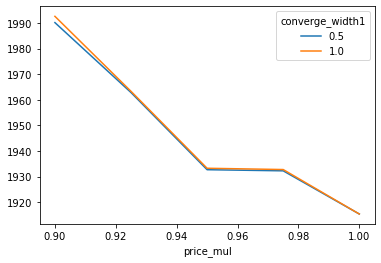

In [219]:
# demand_evolution_m.sum(axis=1).unstack().plot()
# demand_evolution_m.loc[:,(demand_evolution_m>0).any()]
# demand_evolution_m.loc[:,'C93200 RBS_cn'].unstack().plot()
demand_evolution_df.sum(axis=1).loc[idx[:,1,:]].unstack().T.plot()

# Results

In [170]:
demand_new.loc[idx[:,target_scrap]][demand_new.loc[idx[:,target_scrap]]>0]
pd.concat([demand_evolution.loc[abs(demand_evolution.iloc[:,1]-demand_evolution.iloc[:,2])>0.01],
         pd.DataFrame(demand_evolution.sum()).rename(columns={0:'Total'}).T])

1.000    2.035036e+08
0.975    2.032104e+08
0.950    2.029169e+08
0.925    2.026207e+08
0.900    2.023231e+08
dtype: float64

# Checking math / demonstration

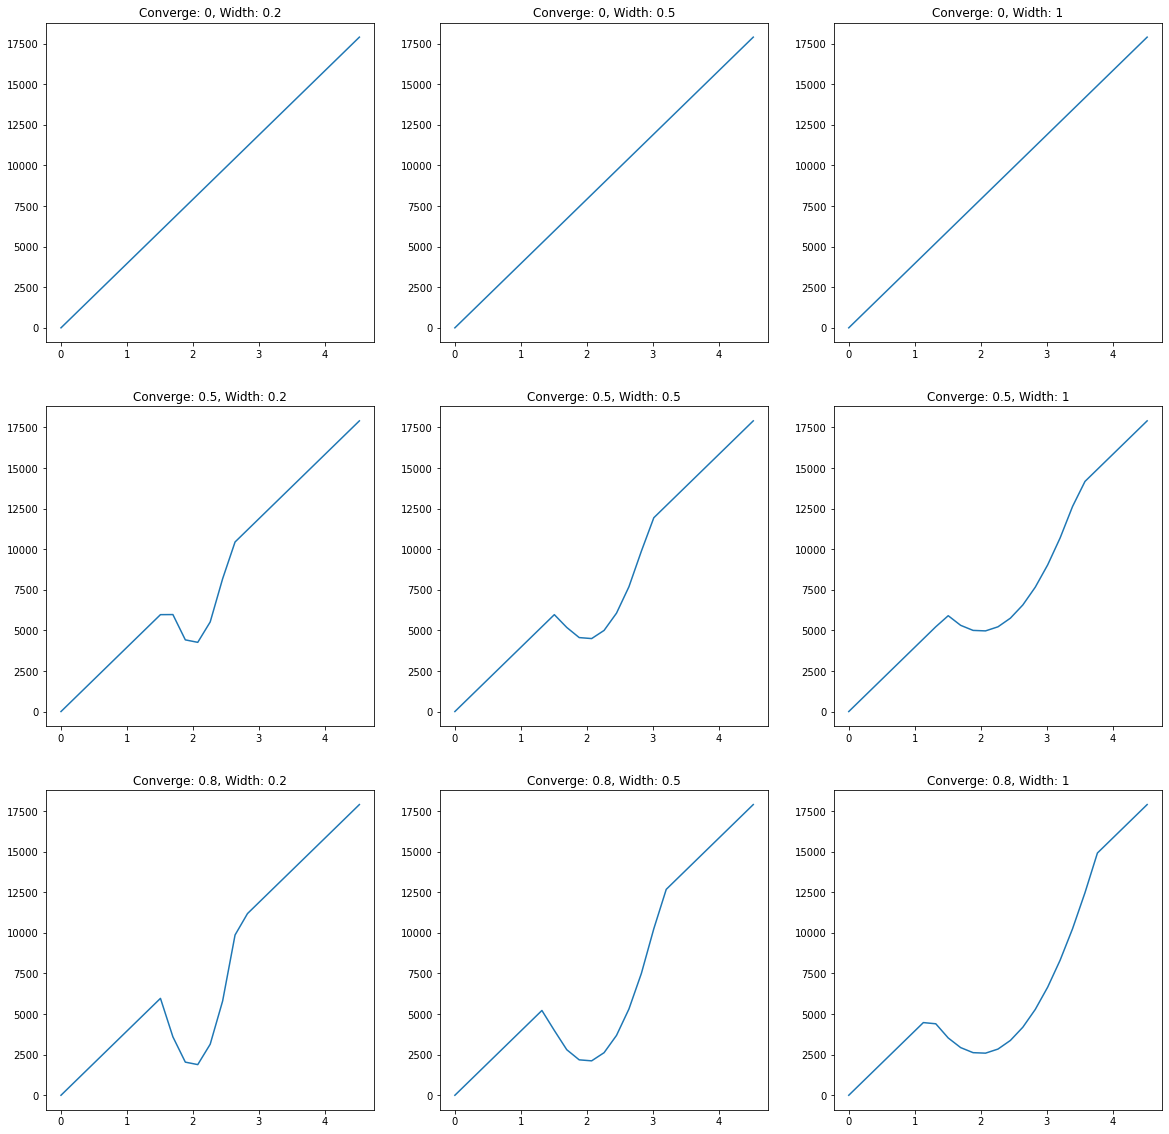

In [37]:
converge_width1 = 2000
converge1 = 0.4
fig,ax = plt.subplots(3,3,figsize=(20,20))
ax = ax.flatten()
i=0
for converge2 in [0,0.5,0.8]:
    for converge_width2 in [0.2,0.5,1]:
        target_name = 'C63200 RBS_cn'
        target_scrap = 'New No.1_cn'
        n=25
        aq = np.linspace(0,prod_params[target_name]['Quantity'],n)
        p = raw_params[target_scrap]['Price']
        target = 2
        x = p/converge_width2*(aq-target-converge_width2/2)**2-converge2*target*p
        x[x>0] = 0
        # raw_params[scrap+'_rw']['Price']*(converge_width*(new_quant_rw['Ref_Cu']-ref_demand_rw))**2-\
        #                 converge*ref_demand_rw*raw_params[scrap+'_rw']['Price']

        bq = aq*p + x # d/d(aq) (bq) = target
        br = aq*p
#         ax[i].plot(aq,bq)
#         ax[i].plot(aq,br)
        ax[i].plot(aq,bq)
        ax[i].set(title='Converge: '+str(converge2)+', Width: '+str(converge_width2))
        i+=1

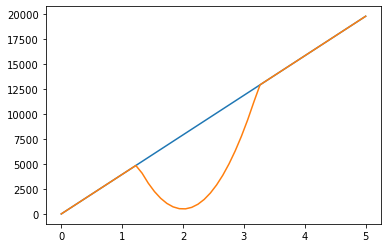

In [129]:
x = np.linspace(0,5)
m = 0.5
y = p*x
y1 = p/m*(x-2-m/2)**2 - 2*p
y1[y1>0] = 0
y1 += y
plt.plot(x,y)
plt.plot(x,y1)

3955.5617996038955

In [3]:
def fun(x, y=0):
    v = x+y
    return v

fun(5,6)

11